## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2024                               # What year to start the run on? (default: 2024)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/pasta.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2024-03-15 15:30:18.726215


{1: 24.0,
 5: 25.3,
 10: 26.1,
 20: 27.0,
 30: 28.3,
 40: 30.1,
 50: 31.9,
 60: 33.7,
 70: 35.7,
 80: 38.2,
 90: 41.6,
 95: 44.5,
 99: 50.0}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "(3A) Initial TAI Spend Model" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
sq.get_percentiles(initial_pay)

Cache from: 2024-03-15 12:27:41.902659


{1: 8.0,
 5: 8.2,
 10: 8.4,
 20: 8.6,
 30: 8.8,
 40: 8.9,
 50: 9.1,
 60: 9.2,
 70: 9.4,
 80: 9.6,
 90: 9.9,
 95: 10.1,
 99: 10.5}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2024-03-15 12:30:55.271687


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.29, lognorm_sd=0.93, norm_mean=1.15, norm_sd=0.28)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev1)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=4.04, lognorm_sd=3.21, norm_mean=1.15, norm_sd=0.7) (version 0.28-dev1)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37) (version 0.28-dev1)},
 'robotics': {'pro

In [6]:
def wildeford_max_gdp_frac():
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.8:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, rclip=0.999)
        percent_spent_on_largest_model = sq.lognorm(0.015, 0.8, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.99, lclip=0.1, rclip=0.999)
        percent_spent_on_largest_model = sq.lognorm(0.01, 0.8, rclip=0.999)

    frac = ~gdp_frac * ~percent_spent_on_compute * ~percent_spent_on_largest_model
    frac = 1 / (4*K) if frac < (1 / (4*K)) else frac
    gpd_frac = 1 / (4*K) if gdp_frac < (1 / (4*K)) else gdp_frac
    return {'total_frac': gdp_frac, 'compute_frac': frac}


# https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
variables = {'initial_gdp': 23.32*T * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03),
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': sq.lognorm(0.75, 3),
             'algo_doubling_rate_min': sq.lognorm(0.5, 2),
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': sq.lognorm(18, 19.5),  # https://docs.google.com/spreadsheets/d/1cLzO_tX9b4z6URKLFvzc0MtsN4GrftkFZuv1bCxeWVY/edit#gid=2058539694
             'flop_halving_rate': sq.norm(2, 3),      # https://epochai.org/blog/trends-in-gpu-price-performance and https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.norm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': lambda: wildeford_max_gdp_frac()['compute_frac'], # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.lognorm(1, 8.5, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

#### Total % of GDP spent on entire project

In [7]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['total_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 47236.66it/s]


{1: 0.0007,
 5: 0.00102,
 10: 0.00128,
 20: 0.00171,
 30: 0.00212,
 40: 0.00257,
 50: 0.00309,
 60: 0.00375,
 70: 0.00493,
 80: 0.00777,
 90: 0.01158,
 95: 0.01453,
 99: 0.02013}

In [8]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.07%',
 5: '0.102%',
 10: '0.128%',
 20: '0.171%',
 30: '0.212%',
 40: '0.257%',
 50: '0.309%',
 60: '0.375%',
 70: '0.493%',
 80: '0.777%',
 90: '1.158%',
 95: '1.453%',
 99: '2.013%'}

In [9]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '17.5 billion',
 5: '25.6 billion',
 10: '32.2 billion',
 20: '42.9 billion',
 30: '53.3 billion',
 40: '64.5 billion',
 50: '77.7 billion',
 60: '94.1 billion',
 70: '123.9 billion',
 80: '195.2 billion',
 90: '290.7 billion',
 95: '364.0 billion',
 99: '504.0 billion'}

#### Total GDP spent on compute for largest model

In [10]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['compute_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 811936.97it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00025,
 50: 0.00026,
 60: 0.00036,
 70: 0.00055,
 80: 0.0009,
 90: 0.00167,
 95: 0.00286,
 99: 0.00703}

In [11]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.025%',
 5: '0.025%',
 10: '0.025%',
 20: '0.025%',
 30: '0.025%',
 40: '0.025%',
 50: '0.026%',
 60: '0.036%',
 70: '0.055%',
 80: '0.09%',
 90: '0.167%',
 95: '0.286%',
 99: '0.703%'}

In [12]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '6.2 billion',
 5: '6.2 billion',
 10: '6.3 billion',
 20: '6.3 billion',
 30: '6.3 billion',
 40: '6.3 billion',
 50: '6.5 billion',
 60: '9.1 billion',
 70: '13.9 billion',
 80: '22.6 billion',
 90: '41.8 billion',
 95: '71.7 billion',
 99: '176.0 billion'}

## Run Wildeford timelines model



## SAMPLE RUN 1 ##

In this simulation:
* It takes 30.3 log FLOP (~2.0 nonillion) for transformative capabilities.
* Every 4.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~10.0 quintillion) per 2024$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~407.9 sextillion) per 2024$USD.
* We are initially willing to pay 9.4 log 2024$USD (~2.4 billion).
* This doubles every 2.5 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.017x per year.
---
2024 - TAI takes 30.3 logFLOP which costs 11.3 log 2024$USD to buy vs. WTP at 9.2 (buys 28.2 log FLOP or 28.2 2024-log-eFLOP)
2025 - TAI takes 30.2 logFLOP which costs 11.1 log 2024$USD to buy vs. WTP at 9.3 (buys 28.4 log FLOP or 28.5 2024-log-eFLOP)
2026 - TAI takes 30.2 logFLOP which costs 10.9 log 2024$USD to buy vs. WTP at 9.4 (buys 28.6 log FLOP or 28.8 2024-log-eFLOP)
2027 - TAI takes 30.1 logFLOP which costs 10.8 l

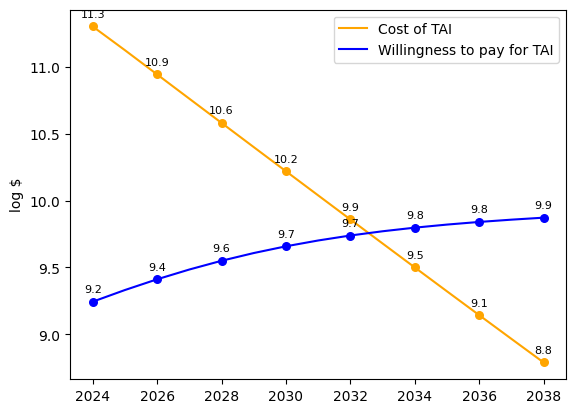



## SAMPLE RUN 2 ##

In this simulation:
* It takes 45.6 log FLOP (~4.0 trillion decillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 2.1 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~937.6 quadrillion) per 2024$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 21.0 log FLOP (~980.2 quintillion) per 2024$USD.
* We are initially willing to pay 8.3 log 2024$USD (~193.4 million).
* This doubles every 4.4 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.014x per year.
---
2024 - TAI takes 45.6 logFLOP which costs 27.6 log 2024$USD to buy vs. WTP at 8.3 (buys 26.2 log FLOP or 26.2 2024-log-eFLOP)
2025 - TAI takes 45.0 logFLOP which costs 27.0 log 2024$USD to buy vs. WTP at 8.3 (buys 26.4 log FLOP or 27.0 2024-log-eFLOP)
2026 - TAI takes 44.5 logFLOP which costs 26.3 log 2024$USD to buy vs. WTP at 8.4 (buys 26.6 log FLOP or 27.7 2024-log-eFLOP)
2027 - TAI takes 44.0 logFLOP whi

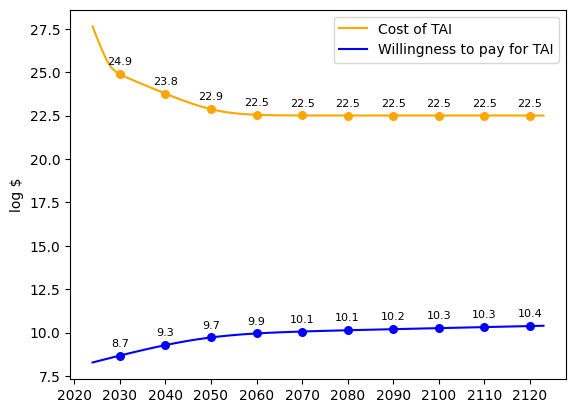



## SAMPLE RUN 3 ##

In this simulation:
* It takes 45.2 log FLOP (~1.6 trillion decillion) for transformative capabilities.
* Every 0.4 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.8 quintillion) per 2024$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~640.9 sextillion) per 2024$USD.
* We are initially willing to pay 8.8 log 2024$USD (~616.0 million).
* This doubles every 1.4 year to a max of 0.103159% of GDP (initially ~25.9 billion 2024$USD).
* GDP grows at a rate of 1.021x per year.
---
2024 - TAI takes 45.2 logFLOP which costs 26.8 log 2024$USD to buy vs. WTP at 8.8 (buys 27.2 log FLOP or 27.2 2024-log-eFLOP)
2025 - TAI takes 44.4 logFLOP which costs 25.9 log 2024$USD to buy vs. WTP at 9.0 (buys 27.5 log FLOP or 28.3 2024-log-eFLOP)
2026 - TAI takes 43.7 logFLOP which costs 25.0 log 2024$USD to buy vs. WTP at 9.2 (buys 27.8 log FLOP or 29.4 2024-log-eFLOP)
2027 - TAI takes 42.9 logFLOP whic

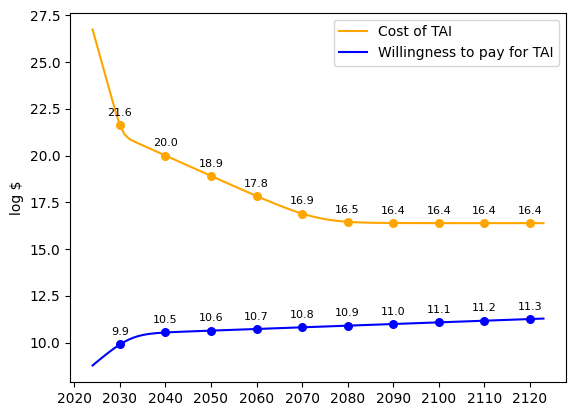



## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 308.81it/s]


Shuffling data...
Writing data...
Waiting for other cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 549.70it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!

## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2029',
 '10%: 2031',
 '15%: 2033',
 '20%: 2034',
 '25%: 2036',
 '35%: 2039',
 '50%: 2046',
 '60%: 2052',
 '75%: 2078',
 '80%: >2124',
 '90%: >2124',
 '95%: >2124']


## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 5 years from now',
 '10%: 7 years from now',
 '15%: 9 years from now',
 '20%: 10 years from now',
 '25%: 12 years from now',
 '35%: 15 years from now',
 '50%: 22 years from now',
 '60%: 28 years from now',
 '75%: 54 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 38 years from now)


## TAI ARRIVAL DATE BY BIN ##
This year: 0.2%
2025-2026: 0.4%
2027-2029: 4.9%
2030-2034: 15.5%
2035-2039: 15.2%
2040-2049: 19.6%
2050-2059: 10.8%
2060-2069: 5.8%
2070-2079: 2.9%
2080-2089: 1.3%
2090-2099: 0.8%
2100-2109: 0.8%
2110-2119: 0.5



## GDP Over Time ##
Year: 2024 - GDP log 2024$USD 13.4 (~25.1 trillion) 80% CI 13.4 (~25.0 trillion) - 13.4 (~25.2 trillion)
Year: 2025 - GDP log 2024$USD 13.4 (~25.7 trillion) 80% CI 13.4 (~25.4 trillion) - 13.4 (~26.0 trillion)
Year: 2026 - GDP log 2024$USD 13.4 (~26.3 trillion) 80% CI 13.4 (~25.8 trillion) - 13.4 (~26.7 trillion)
Year: 2027 - GDP log 2024$USD 13.4 (~26.8 trillion) 80% CI 13.4 (~26.3 trillion) - 13.4 (~27.5 trillion)
Year: 2028 - GDP log 2024$USD 13.4 (~27.4 trillion) 80% CI 13.4 (~26.7 trillion) - 13.5 (~28.3 trillion)
Year: 2029 - GDP log 2024$USD 13.4 (~28.1 trillion) 80% CI 13.4 (~27.1 trillion) - 13.5 (~29.1 trillion)
Year: 2030 - GDP log 2024$USD 13.5 (~28.7 trillion) 80% CI 13.4 (~27.6 trillion) - 13.5 (~30.0 trillion)
Year: 2031 - GDP log 2024$USD 13.5 (~29.3 trillion) 80% CI 13.4 (~28.0 trillion) - 13.5 (~30.8 trillion)
Year: 2032 - GDP log 2024$USD 13.5 (~30.0 trillion) 80% CI 13.5 (~28.5 trillion) - 13.5 (~31.7 trillion)
Year: 2033 - GDP log 2024$USD 13.

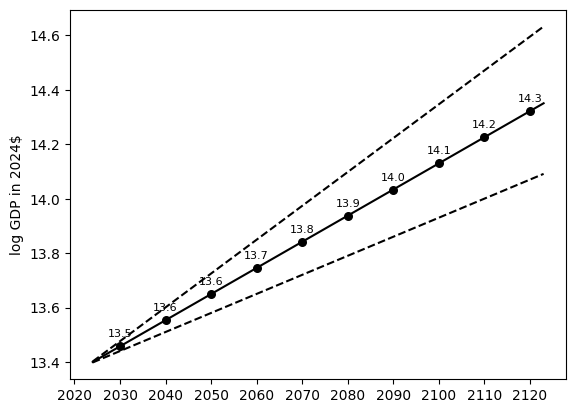

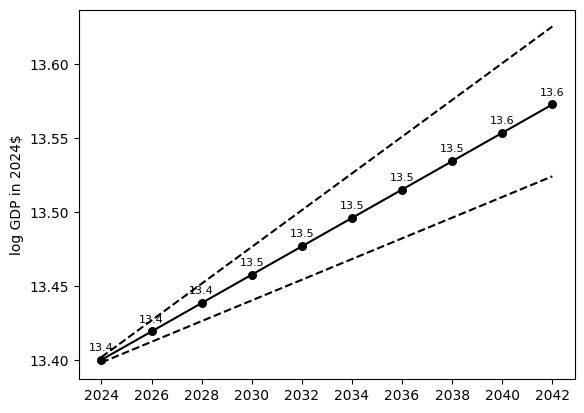



## Willingness to Pay Over Time ##
Year: 2024 - willingness log 2024$USD per year 9.0 (~1.0 billion) 80% CI 8.6 (~374.3 million) - 9.5 (~3.4 billion)
Year: 2025 - willingness log 2024$USD per year 9.1 (~1.3 billion) 80% CI 8.7 (~541.3 million) - 9.6 (~3.8 billion)
Year: 2026 - willingness log 2024$USD per year 9.2 (~1.5 billion) 80% CI 8.9 (~774.1 million) - 9.6 (~4.3 billion)
Year: 2027 - willingness log 2024$USD per year 9.3 (~1.9 billion) 80% CI 9.0 (~1.1 billion) - 9.7 (~4.8 billion)
Year: 2028 - willingness log 2024$USD per year 9.3 (~2.2 billion) 80% CI 9.2 (~1.5 billion) - 9.7 (~5.4 billion)
Year: 2029 - willingness log 2024$USD per year 9.4 (~2.6 billion) 80% CI 9.3 (~2.0 billion) - 9.8 (~6.0 billion)
Year: 2030 - willingness log 2024$USD per year 9.5 (~3.0 billion) 80% CI 9.4 (~2.6 billion) - 9.8 (~6.7 billion)
Year: 2031 - willingness log 2024$USD per year 9.5 (~3.5 billion) 80% CI 9.5 (~3.3 billion) - 9.9 (~7.5 billion)
Year: 2032 - willingness log 2024$USD per year 9.6 (~

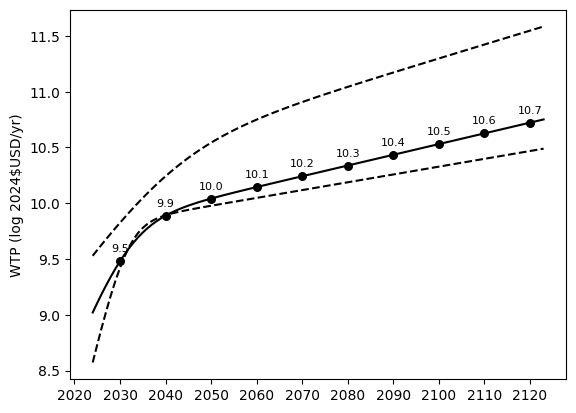

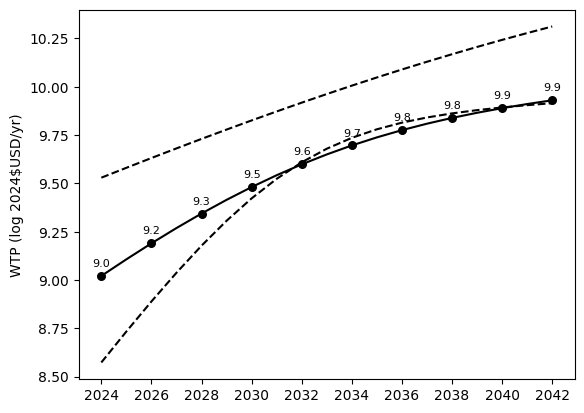



## Actual FLOP Needed to Make TAI (Given Algorithmic Progress) ##
Year: 2024 - logFLOP needed for TAI 32.0 (~100.0 nonillion) 80% CI 27.0 (~1.0 octillion) - 37.7 (~55.0 thousand decillion)
Year: 2025 - logFLOP needed for TAI 31.7 (~51.3 nonillion) 80% CI 26.7 (~528.5 septillion) - 37.5 (~33.8 thousand decillion)
Year: 2026 - logFLOP needed for TAI 31.4 (~26.3 nonillion) 80% CI 26.4 (~278.8 septillion) - 37.3 (~20.8 thousand decillion)
Year: 2027 - logFLOP needed for TAI 31.1 (~13.7 nonillion) 80% CI 26.2 (~149.4 septillion) - 37.1 (~12.8 thousand decillion)
Year: 2028 - logFLOP needed for TAI 30.9 (~7.4 nonillion) 80% CI 25.9 (~82.3 septillion) - 36.9 (~7.9 thousand decillion)
Year: 2029 - logFLOP needed for TAI 30.6 (~4.2 nonillion) 80% CI 25.7 (~47.5 septillion) - 36.7 (~4.9 thousand decillion)
Year: 2030 - logFLOP needed for TAI 30.4 (~2.6 nonillion) 80% CI 25.5 (~29.4 septillion) - 36.5 (~3.0 thousand decillion)
Year: 2031 - logFLOP needed for TAI 30.3 (~1.8 nonillion) 80% CI 25.

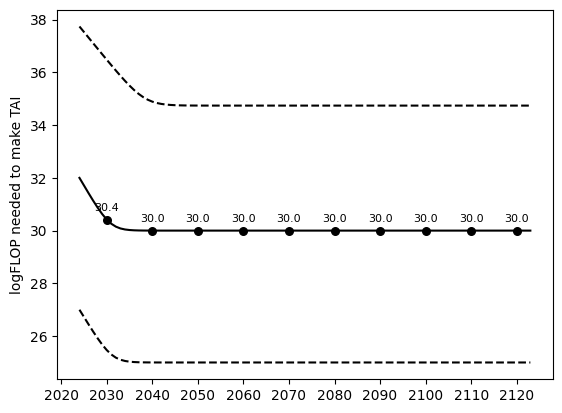

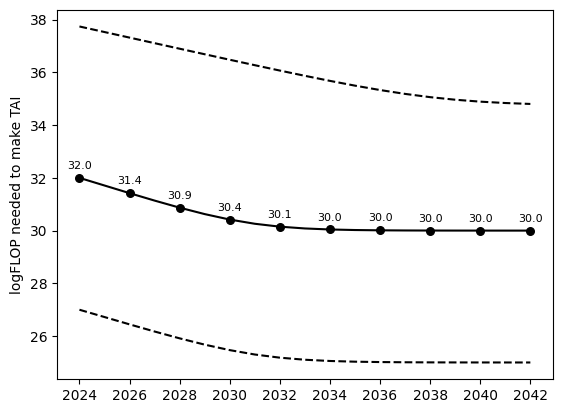



## FLOP per Dollar (Given Declining Costs) ##
Year: 2024 - logFLOP per 2024$1USD 18.7 (~5.2 quintillion) 80% CI 18.3 (~2.1 quintillion) - 19.1 (~12.3 quintillion)
Year: 2025 - logFLOP per 2024$1USD 18.8 (~6.8 quintillion) 80% CI 18.5 (~2.9 quintillion) - 19.2 (~15.9 quintillion)
Year: 2026 - logFLOP per 2024$1USD 19.0 (~9.0 quintillion) 80% CI 18.6 (~3.9 quintillion) - 19.3 (~20.5 quintillion)
Year: 2027 - logFLOP per 2024$1USD 19.1 (~11.9 quintillion) 80% CI 18.7 (~5.3 quintillion) - 19.4 (~26.4 quintillion)
Year: 2028 - logFLOP per 2024$1USD 19.2 (~15.8 quintillion) 80% CI 18.9 (~7.2 quintillion) - 19.5 (~34.0 quintillion)
Year: 2029 - logFLOP per 2024$1USD 19.3 (~20.8 quintillion) 80% CI 19.0 (~9.9 quintillion) - 19.6 (~43.8 quintillion)
Year: 2030 - logFLOP per 2024$1USD 19.4 (~27.6 quintillion) 80% CI 19.1 (~13.4 quintillion) - 19.8 (~56.4 quintillion)
Year: 2031 - logFLOP per 2024$1USD 19.6 (~36.4 quintillion) 80% CI 19.3 (~18.3 quintillion) - 19.9 (~72.7 quintillion)
Year: 203

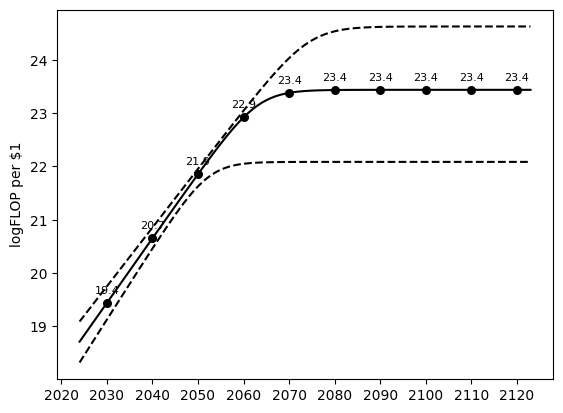

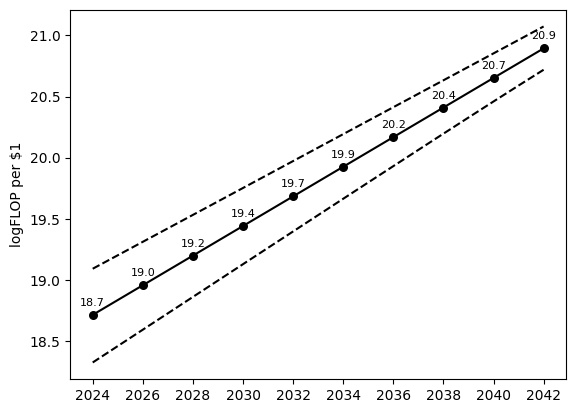



## Max Possible OOM Reduction in TAI FLOP Size ##
TAI log FLOP 20 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2

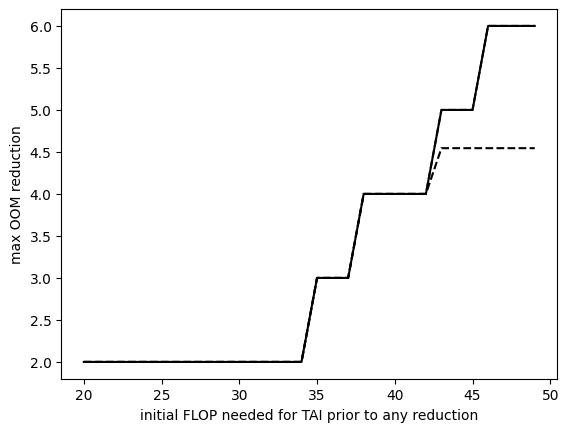



## Halving time (years) of compute requirements ##
TAI log FLOP 20 -> algo doubling rate 1.53yrs (80% CI: 2.07 to 2.07)
TAI log FLOP 21 -> algo doubling rate 1.53yrs (80% CI: 2.07 to 2.07)
TAI log FLOP 22 -> algo doubling rate 1.53yrs (80% CI: 2.07 to 2.07)
TAI log FLOP 23 -> algo doubling rate 1.53yrs (80% CI: 2.07 to 2.07)
TAI log FLOP 24 -> algo doubling rate 1.53yrs (80% CI: 2.07 to 2.07)
TAI log FLOP 25 -> algo doubling rate 1.53yrs (80% CI: 2.07 to 2.07)
TAI log FLOP 26 -> algo doubling rate 1.53yrs (80% CI: 2.07 to 2.07)
TAI log FLOP 27 -> algo doubling rate 1.53yrs (80% CI: 2.07 to 2.07)
TAI log FLOP 28 -> algo doubling rate 1.53yrs (80% CI: 2.07 to 2.07)
TAI log FLOP 29 -> algo doubling rate 1.53yrs (80% CI: 2.07 to 2.07)
TAI log FLOP 30 -> algo doubling rate 1.53yrs (80% CI: 2.07 to 2.07)
TAI log FLOP 31 -> algo doubling rate 1.03yrs (80% CI: 1.57 to 1.57)
TAI log FLOP 32 -> algo doubling rate 1.01yrs (80% CI: 1.07 to 1.07)
TAI log FLOP 33 -> algo doubling rate 1.01yrs (80%

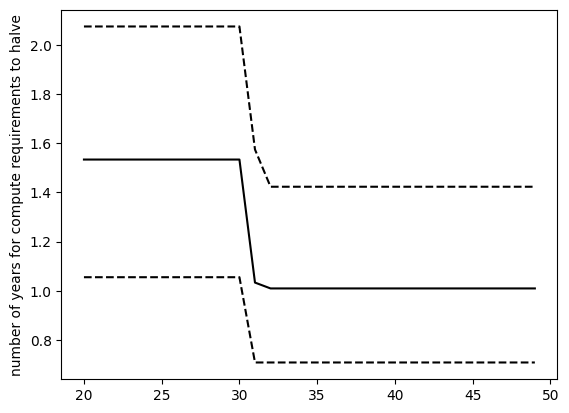



## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP) ##
Year: 2024 - 13.3 log 2024$USD to buy TAI (~19.4 trillion) 80% CI 8.7 (~475.0 million) - 18.6 (~4.5 quintillion)
Year: 2025 - 12.9 log 2024$USD to buy TAI (~7.5 trillion) 80% CI 8.3 (~184.3 million) - 18.3 (~2.1 quintillion)
Year: 2026 - 12.5 log 2024$USD to buy TAI (~2.9 trillion) 80% CI 7.9 (~71.4 million) - 18.0 (~1.0 quintillion)
Year: 2027 - 12.1 log 2024$USD to buy TAI (~1.2 trillion) 80% CI 7.4 (~28.1 million) - 17.7 (~485.5 quadrillion)
Year: 2028 - 11.7 log 2024$USD to buy TAI (~470.3 billion) 80% CI 7.1 (~11.4 million) - 17.4 (~232.1 quadrillion)
Year: 2029 - 11.3 log 2024$USD to buy TAI (~202.9 billion) 80% CI 6.7 (~4.8 million) - 17.0 (~111.1 quadrillion)
Year: 2030 - 11.0 log 2024$USD to buy TAI (~95.3 billion) 80% CI 6.3 (~2.2 million) - 16.7 (~53.4 quadrillion)
Year: 2031 - 10.7 log 2024$USD to buy TAI (~49.9 billion) 80% CI 6.0 (~1.1 million) - 16.4 (~25.7 quadrillion)
Year: 2032

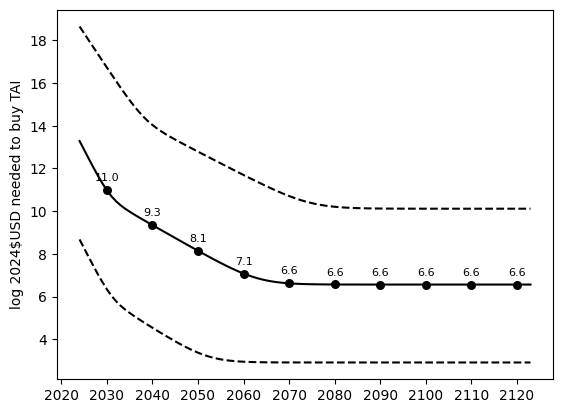

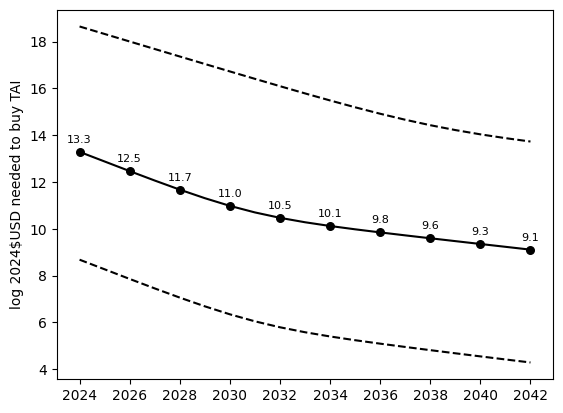



## Actual FLOP at Max Spend ##
Year: 2024 - max log FLOP 27.7 (~5.4 octillion) 80% CI 26.9 (~788.0 septillion) - 28.6 (~41.7 octillion)
Year: 2025 - max log FLOP 27.9 (~8.7 octillion) 80% CI 27.2 (~1.6 octillion) - 28.8 (~60.4 octillion)
Year: 2026 - max log FLOP 28.1 (~14.0 octillion) 80% CI 27.5 (~3.0 octillion) - 28.9 (~87.5 octillion)
Year: 2027 - max log FLOP 28.3 (~22.2 octillion) 80% CI 27.8 (~5.8 octillion) - 29.1 (~126.5 octillion)
Year: 2028 - max log FLOP 28.5 (~34.8 octillion) 80% CI 28.0 (~10.9 octillion) - 29.3 (~182.5 octillion)
Year: 2029 - max log FLOP 28.7 (~54.2 octillion) 80% CI 28.3 (~20.0 octillion) - 29.4 (~262.8 octillion)
Year: 2030 - max log FLOP 28.9 (~83.4 octillion) 80% CI 28.6 (~35.5 octillion) - 29.6 (~377.7 octillion)
Year: 2031 - max log FLOP 29.1 (~127.0 octillion) 80% CI 28.8 (~61.0 octillion) - 29.7 (~541.7 octillion)
Year: 2032 - max log FLOP 29.3 (~191.1 octillion) 80% CI 29.0 (~101.1 octillion) - 29.9 (~775.3 octillion)
Year: 2033 - max log FLOP

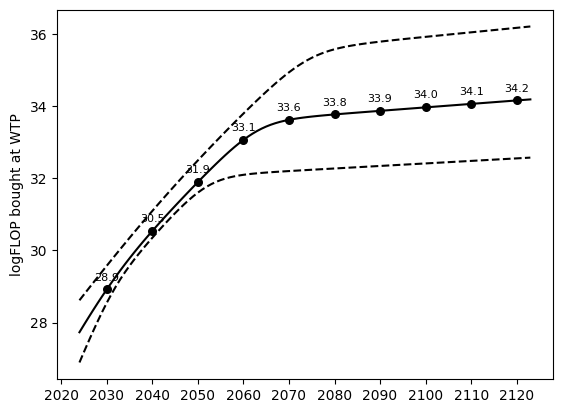

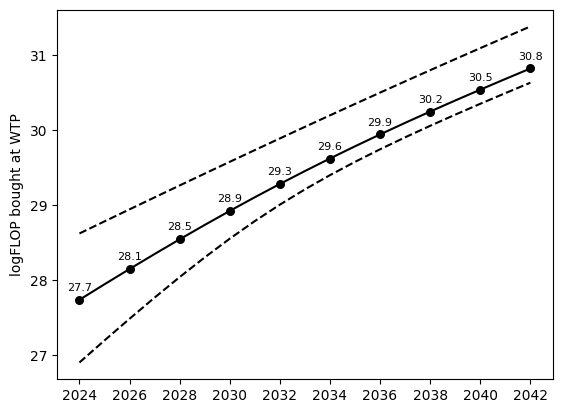



## Effective 2024-FLOP at Max Spend (given algorithmic progress and decline in $/FLOP) ##
Year: 2024 - max log effective 2024-FLOP 27.7 (~5.4 octillion) 80% CI 26.9 (~788.0 septillion) - 28.6 (~41.7 octillion)
Year: 2025 - max log effective 2024-FLOP 28.2 (~17.0 octillion) 80% CI 27.4 (~2.5 octillion) - 29.2 (~160.3 octillion)
Year: 2026 - max log effective 2024-FLOP 28.7 (~53.0 octillion) 80% CI 27.9 (~7.8 octillion) - 29.8 (~614.5 octillion)
Year: 2027 - max log effective 2024-FLOP 29.2 (~161.1 octillion) 80% CI 28.4 (~24.0 octillion) - 30.4 (~2.3 nonillion)
Year: 2028 - max log effective 2024-FLOP 29.7 (~469.5 octillion) 80% CI 28.9 (~71.5 octillion) - 30.9 (~8.7 nonillion)
Year: 2029 - max log effective 2024-FLOP 30.1 (~1.3 nonillion) 80% CI 29.3 (~204.7 octillion) - 31.5 (~30.9 nonillion)
Year: 2030 - max log effective 2024-FLOP 30.5 (~3.2 nonillion) 80% CI 29.7 (~556.6 octillion) - 32.0 (~98.7 nonillion)
Year: 2031 - max log effective 2024-FLOP 30.8 (~7.0 nonillion) 80% CI 30.2

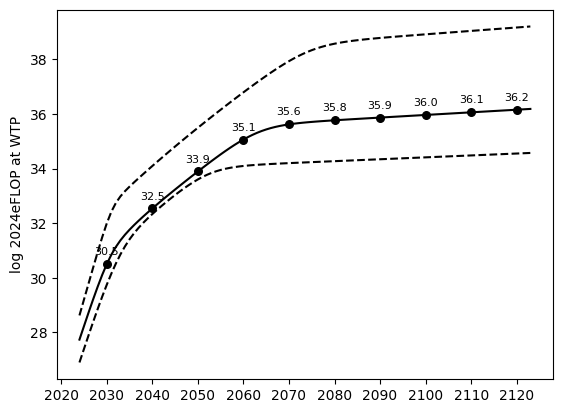

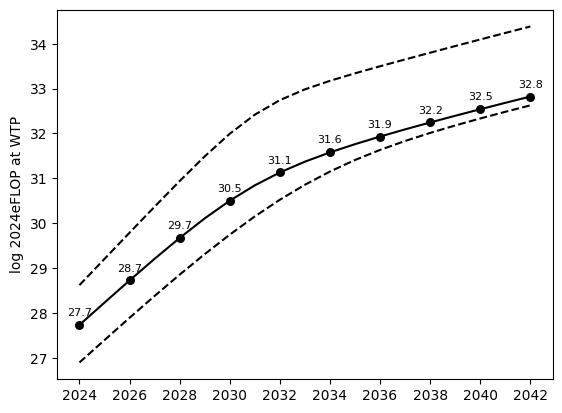


## TAI FLOP SIZE ##
{1: 24.0,
 5: 25.2,
 10: 26.1,
 20: 27.0,
 30: 28.6,
 40: 30.2,
 50: 32.0,
 60: 33.8,
 70: 35.7,
 80: 37.74000000000001,
 90: 41.11000000000001,
 95: 44.0,
 99: 52.5}


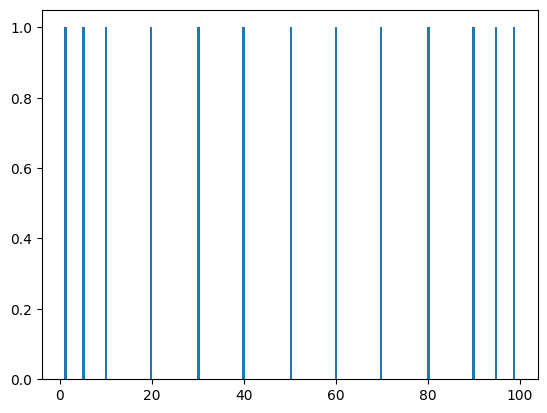



## MIN REDUCTION: 2 ##

## MAX REDUCTION ##
{1: 2.0598224442113913,
 5: 2.874273986566449,
 10: 3.4817665840757153,
 20: 4.544671216760399,
 30: 5.247319044863398,
 40: 5.896448838655729,
 50: 6.747748731499215,
 60: 7.562827526441902,
 70: 8.738946951153803,
 80: 10.539268669478673,
 90: 13.078927424131525,
 95: 15.729087428981057,
 99: 20.785542489694834}


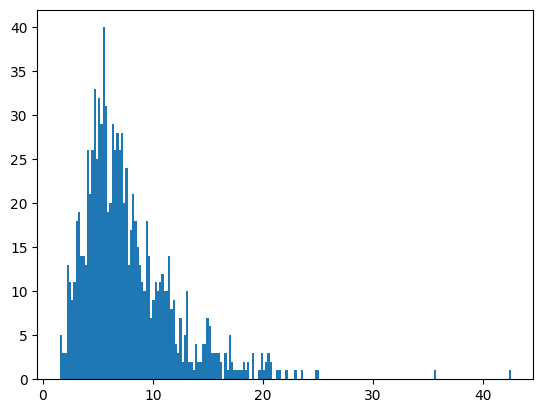



## MIN ALGO DOUBLING RATE ##
{1: 0.3661649564692909,
 5: 0.5144111325001317,
 10: 0.6029657406030732,
 20: 0.7086589702643152,
 30: 0.8108135541459339,
 40: 0.9211743988293339,
 50: 1.0095798498280502,
 60: 1.1151978433107703,
 70: 1.2447900703257546,
 80: 1.4228553351642437,
 90: 1.7537319938996832,
 95: 2.0585920411796583,
 99: 2.7048355458074145}


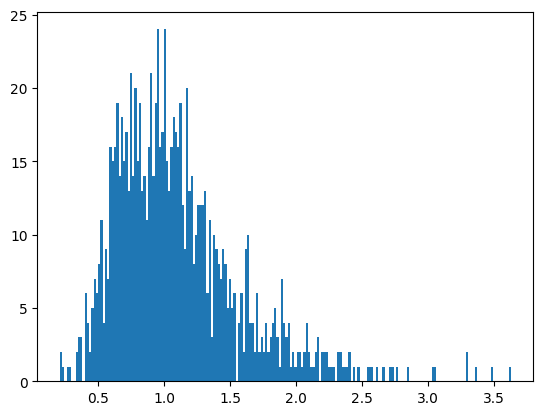



## MAX ALGO DOUBLING RATE ##
{1: 0.5902619246089779,
 5: 0.7654265407357591,
 10: 0.8850302979500242,
 20: 1.0551825752831483,
 30: 1.2254538091567124,
 40: 1.3874407738066696,
 50: 1.5333743976525407,
 60: 1.6669938874929136,
 70: 1.840871086826357,
 80: 2.0741596228150456,
 90: 2.422714994357048,
 95: 2.901982754189639,
 99: 3.845101585770473}


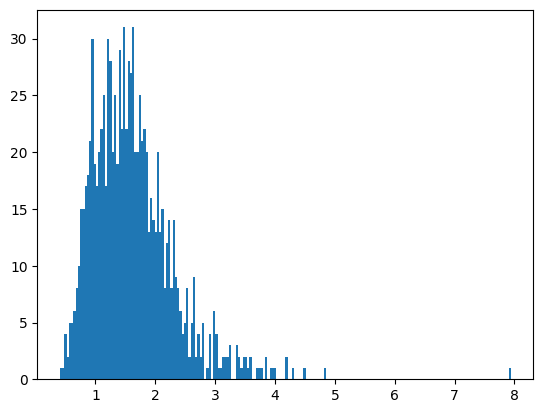



## INITIAL FLOP PER DOLLAR ##
{1: 17.639134872604547,
 5: 17.961357584853115,
 10: 18.12073425873943,
 20: 18.32342276031372,
 30: 18.46226428776274,
 40: 18.593294159275153,
 50: 18.712978825689774,
 60: 18.81836281405929,
 70: 18.937456634142897,
 80: 19.090515981288295,
 90: 19.333311198485145,
 95: 19.489759740532193,
 99: 19.76604309875934}


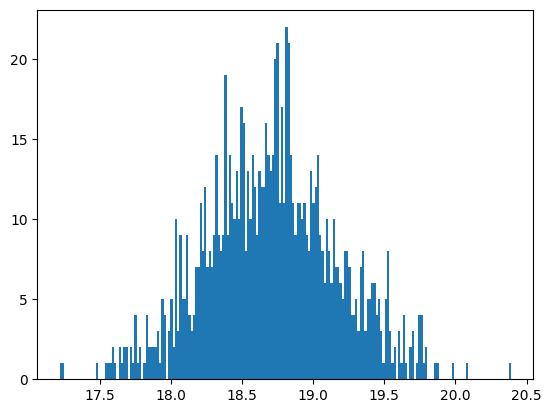



## FLOP HALVING RATE ##
{1: 1.8630597157141413,
 5: 2.031456345709808,
 10: 2.121143029635457,
 20: 2.2441192260528733,
 30: 2.3364992348211078,
 40: 2.4071119004321337,
 50: 2.4832576112168683,
 60: 2.5660618417091885,
 70: 2.638848633430217,
 80: 2.732853100387318,
 90: 2.8783280148021064,
 95: 3.0089165803892417,
 99: 3.2213503032443853}


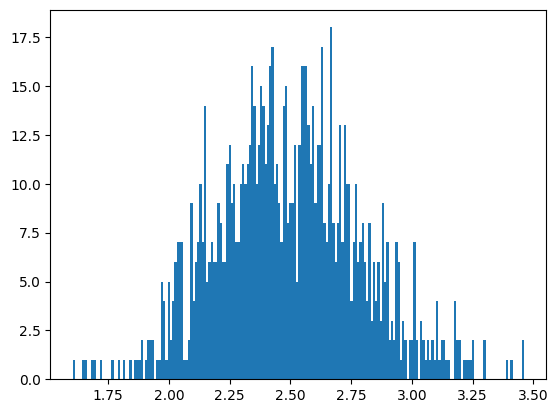



## MAX FLOP PER DOLLAR ##
{1: 19.93186690443,
 5: 20.85634158994947,
 10: 21.380230502932232,
 20: 22.084545550237532,
 30: 22.611308330110717,
 40: 22.99394034806169,
 50: 23.435723212186097,
 60: 23.864860429277748,
 70: 24.24641081835866,
 80: 24.62357814453088,
 90: 25.268260013815677,
 95: 26.180899046303228,
 99: 27.21298369906991}


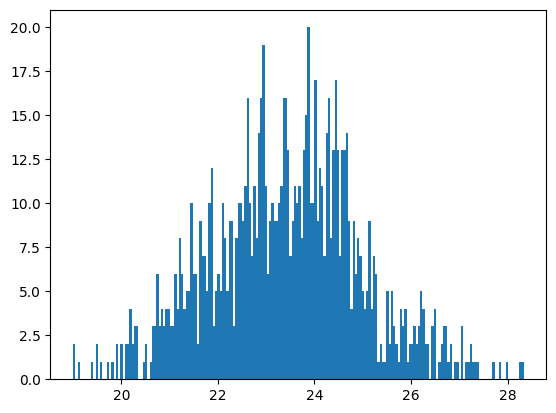



## INITIAL PAY ##
{1: 8.1,
 5: 8.3,
 10: 8.4,
 20: 8.6,
 30: 8.8,
 40: 8.9,
 50: 9.1,
 60: 9.2,
 70: 9.4,
 80: 9.6,
 90: 9.9,
 95: 10.1,
 99: 10.600999999999999}


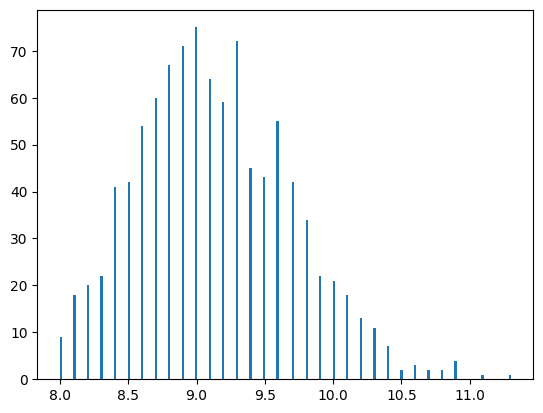



## INITIAL GDP ##
{1: 24819324693256.53,
 5: 24906275060071.605,
 10: 24952861106464.785,
 20: 25017138364878.484,
 30: 25054989734079.15,
 40: 25088241454106.375,
 50: 25121045516098.977,
 60: 25151273917838.0,
 70: 25185860968111.39,
 80: 25226191596310.9,
 90: 25279107198315.348,
 95: 25332233059641.008,
 99: 25407845368734.582}


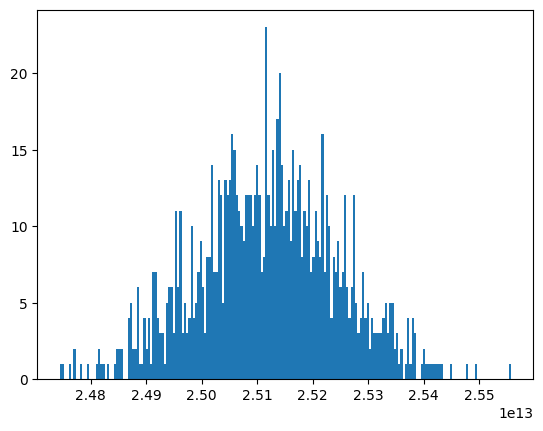



## GDP GROWTH ##
{1: 1.005,
 5: 1.0104129698777482,
 10: 1.0129575499197094,
 20: 1.0162514583985245,
 30: 1.0186917465321186,
 40: 1.020614635121444,
 50: 1.022360548926563,
 60: 1.0244112727074024,
 70: 1.026527922927901,
 80: 1.0290496256617987,
 90: 1.0319125390870103,
 95: 1.0349031251365246,
 99: 1.0408225199796755}


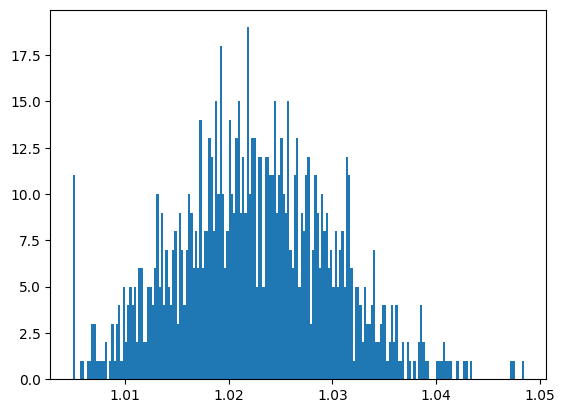



## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00025,
 50: 0.00025150608280567944,
 60: 0.0003615029895853542,
 70: 0.0005227262124221822,
 80: 0.0008944050534050644,
 90: 0.001542156055462266,
 95: 0.0029855850881913004,
 99: 0.007089252342399985}


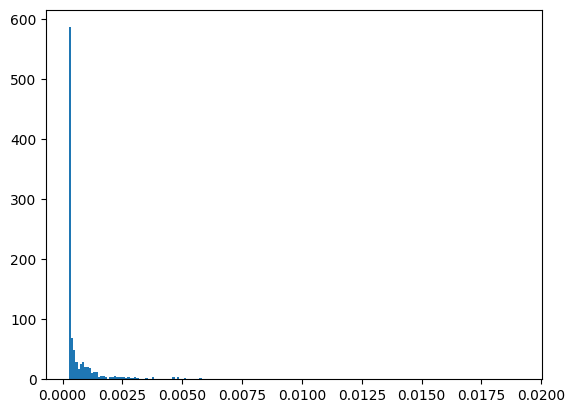



## SPEND DOUBLING TIME ##
{1: 0.9,
 5: 0.9792820635068303,
 10: 1.2470481641167679,
 20: 1.7489177519167365,
 30: 2.1165013013509144,
 40: 2.483403520367044,
 50: 2.9267918394092796,
 60: 3.454326643152661,
 70: 4.16278203924461,
 80: 5.151429977229785,
 90: 6.923871282036102,
 95: 8.599930062691262,
 99: 12.417926363292064}


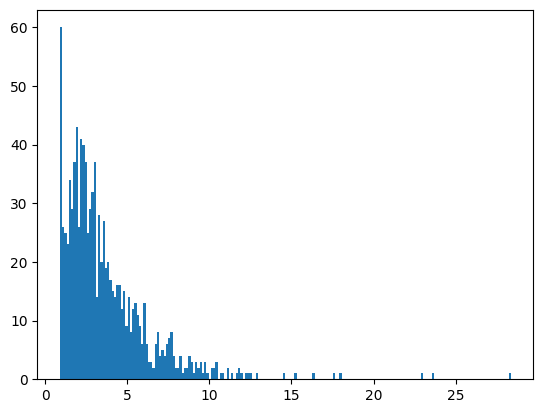





## Nonscaling delay ##
There are 7 ways a non-scaling delay could happen.
- algorithms: additional <Distribution> mixture
 - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.29, lognorm_sd=0.93, norm_mean=1.15, norm_sd=0.28)
 - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) years if it happens
{1: 2,
 5: 2,
 10: 2,
 20: 3,
 30: 3,
 40: 3,
 50: 3,
 60: 4,
 70: 4,
 80: 4,
 90: 5,
 95: 8,
 99: 14}
## Chance of nonscaling delay ##


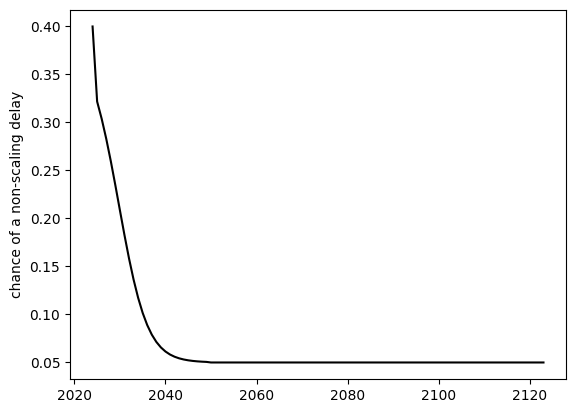

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 32%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2034

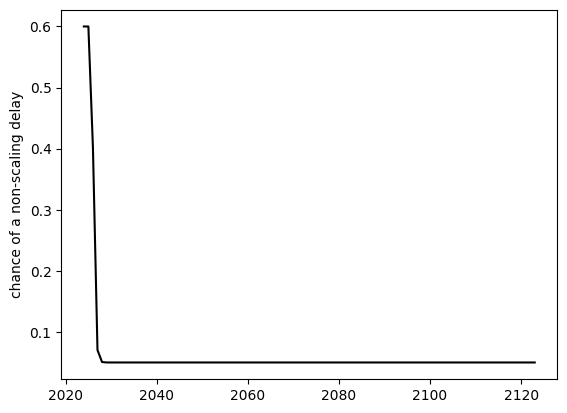

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2034 - chan

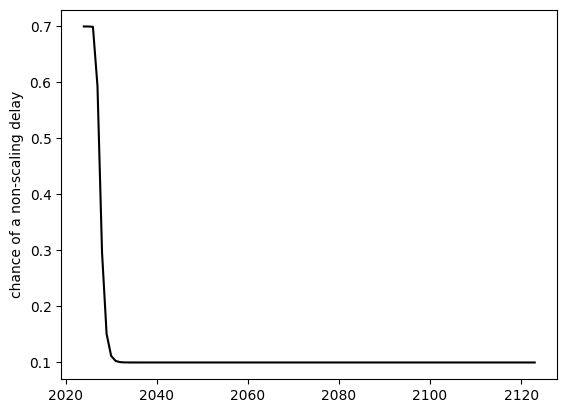

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 59%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2034

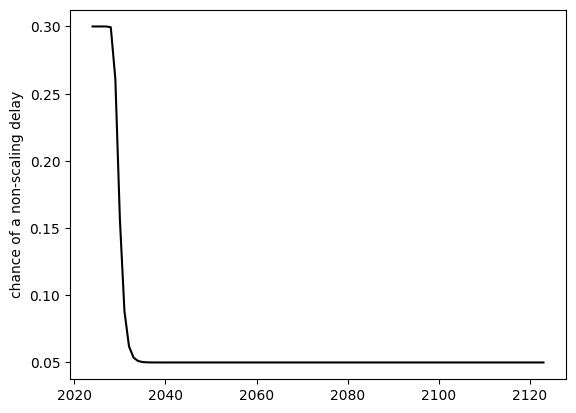

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2034 - 

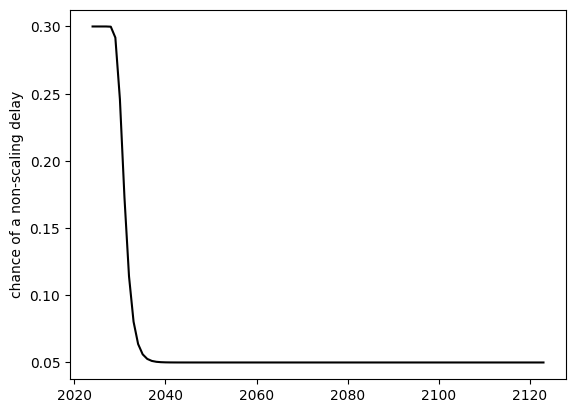

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2034 

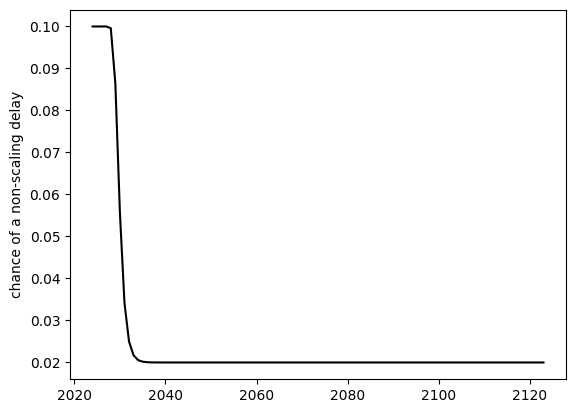

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 3%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 3%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2034 - ch

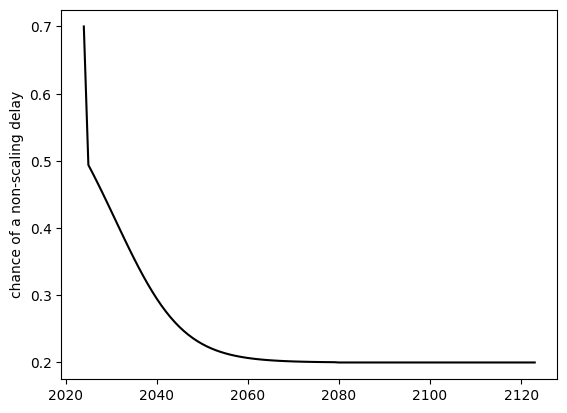

Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 49%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 48%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 47%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 45%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 44%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 43%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 41%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 38%
Year: 2034

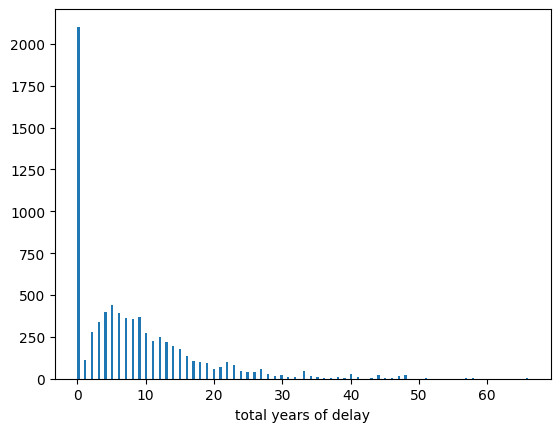

In [13]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##

In this simulation:
* It takes 35.3 log FLOP (~199.5 decillion) for transformative capabilities.
* Every 0.4 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~861.4 quadrillion) per 2024$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~568.9 sextillion) per 2024$USD.
* We are initially willing to pay 9.5 log 2024$USD (~3.2 billion).
* This doubles every 1.3 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.015x per year.
---
2024 - TAI takes 35.3 logFLOP which costs 17.4 log 2024$USD to buy vs. WTP at 9.3 (buys 27.3 log FLOP or 27.3 2024-log-eFLOP)
2025 - TAI takes 34.5 logFLOP which costs 16.4 log 2024$USD to buy vs. WTP at 9.5 (buys 27.5 log FLOP or 28.3 2024-log-eFLOP)
2026 - TAI takes 33.7 logFLOP which costs 15.5 log 2024$USD to buy vs. WTP at 9.6 (buys 27.8 log FLOP or 29.4 2024-log-eFLOP)
2027 - TAI takes 33.0 logFLOP which costs 1

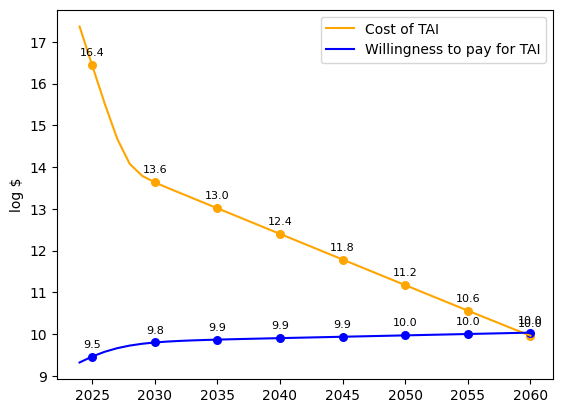

-
-
## SAMPLE RUN 5 ##

In this simulation:
* It takes 31.3 log FLOP (~20.0 nonillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.3 log FLOP (~18.5 quintillion) per 2024$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1.1 septillion) per 2024$USD.
* We are initially willing to pay 9.0 log 2024$USD (~1.1 billion).
* This doubles every 1.3 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.017x per year.
---
2024 - TAI takes 31.3 logFLOP which costs 12.0 log 2024$USD to buy vs. WTP at 9.0 (buys 28.2 log FLOP or 28.2 2024-log-eFLOP)
2025 - TAI takes 31.1 logFLOP which costs 11.7 log 2024$USD to buy vs. WTP at 9.1 (buys 28.5 log FLOP or 28.7 2024-log-eFLOP)
2026 - TAI takes 30.9 logFLOP which costs 11.4 log 2024$USD to buy vs. WTP at 9.3 (buys 28.8 log FLOP or 29.2 2024-log-eFLOP)
2027 - TAI takes 30.7 logFLOP which costs 11.0 

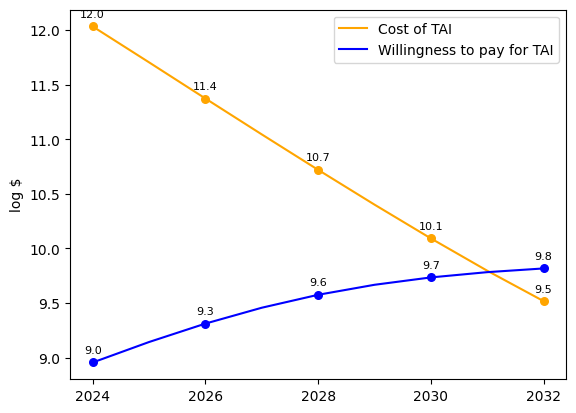

-
-
## SAMPLE RUN 6 ##

In this simulation:
* It takes 32.6 log FLOP (~398.1 nonillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.8 quintillion) per 2024$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 25.8 log FLOP (~68.1 septillion) per 2024$USD.
* We are initially willing to pay 8.9 log 2024$USD (~872.9 million).
* This doubles every 1.5 year to a max of 0.027333% of GDP (initially ~6.9 billion 2024$USD).
* GDP grows at a rate of 1.027x per year.
---
2024 - TAI takes 32.6 logFLOP which costs 13.7 log 2024$USD to buy vs. WTP at 8.9 (buys 27.8 log FLOP or 27.8 2024-log-eFLOP)
2025 - TAI takes 32.2 logFLOP which costs 13.1 log 2024$USD to buy vs. WTP at 9.1 (buys 28.1 log FLOP or 28.5 2024-log-eFLOP)
2026 - TAI takes 31.8 logFLOP which costs 12.6 log 2024$USD to buy vs. WTP at 9.2 (buys 28.4 log FLOP or 29.2 2024-log-eFLOP)
2027 - TAI takes 31.4 logFLOP which costs

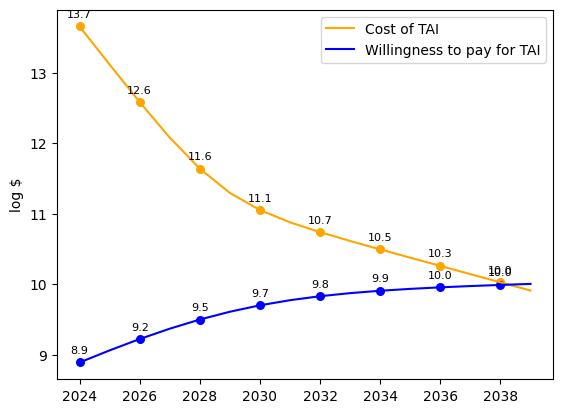

-
-
## SAMPLE RUN 7 ##

In this simulation:
* It takes 41.4 log FLOP (~251.2 million decillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.2 quintillion) per 2024$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8.7 sextillion) per 2024$USD.
* We are initially willing to pay 9.8 log 2024$USD (~5.7 billion).
* This doubles every 1.9 year to a max of 0.029676% of GDP (initially ~7.4 billion 2024$USD).
* GDP grows at a rate of 1.014x per year.
---
2024 - TAI takes 41.4 logFLOP which costs 22.8 log 2024$USD to buy vs. WTP at 9.5 (buys 28.1 log FLOP or 28.1 2024-log-eFLOP)
2025 - TAI takes 41.2 logFLOP which costs 22.5 log 2024$USD to buy vs. WTP at 9.6 (buys 28.3 log FLOP or 28.5 2024-log-eFLOP)
2026 - TAI takes 41.0 logFLOP which costs 22.1 log 2024$USD to buy vs. WTP at 9.7 (buys 28.5 log FLOP or 28.9 2024-log-eFLOP)
2027 - TAI takes 40.8 logFLOP which 

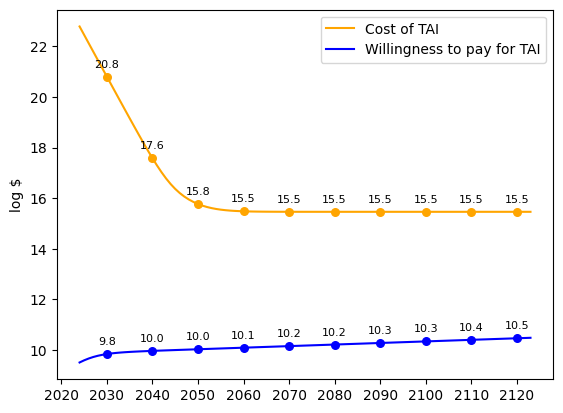

-
-
## SAMPLE RUN 8 ##

In this simulation:
* It takes 28.5 log FLOP (~31.6 octillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.3 quintillion) per 2024$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 20.9 log FLOP (~882.4 quintillion) per 2024$USD.
* We are initially willing to pay 8.9 log 2024$USD (~776.4 million).
* This doubles every 5.0 year to a max of 0.136715% of GDP (initially ~34.4 billion 2024$USD).
* GDP grows at a rate of 1.033x per year.
---
2024 - TAI takes 28.5 logFLOP which costs 9.7 log 2024$USD to buy vs. WTP at 8.9 (buys 27.7 log FLOP or 27.7 2024-log-eFLOP)
2025 - TAI takes 28.4 logFLOP which costs 9.4 log 2024$USD to buy vs. WTP at 8.9 (buys 27.9 log FLOP or 28.0 2024-log-eFLOP)
2026 - TAI takes 28.2 logFLOP which costs 9.2 log 2024$USD to buy vs. WTP at 9.0 (buys 28.0 log FLOP or 28.3 2024-log-eFLOP)
2027 - TAI takes 28.1 logFLOP which costs 

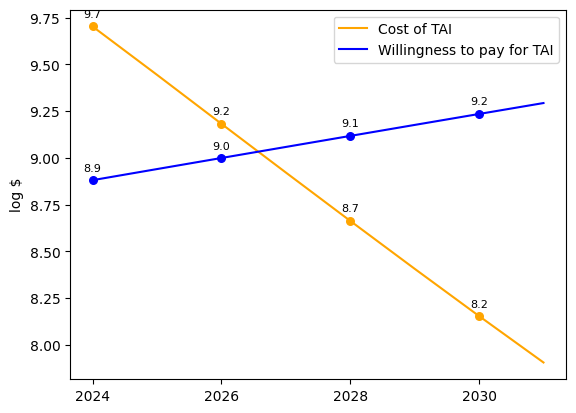

-
-
## SAMPLE RUN 9 ##

In this simulation:
* It takes 27.0 log FLOP (~1.0 octillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.2 quintillion) per 2024$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~5.8 sextillion) per 2024$USD.
* We are initially willing to pay 8.7 log 2024$USD (~464.3 million).
* This doubles every 2.8 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.028x per year.
---
2024 - TAI takes 27.0 logFLOP which costs 8.4 log 2024$USD to buy vs. WTP at 8.6 (buys 27.3 log FLOP or 27.3 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 4 years)
-- r

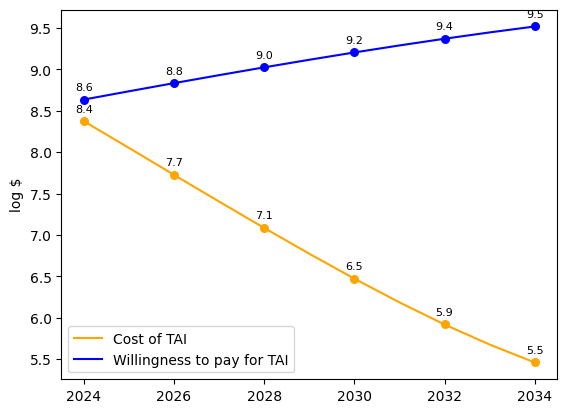

-
-
## SAMPLE RUN 10 ##

In this simulation:
* It takes 25.9 log FLOP (~79.4 septillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~3.9 quintillion) per 2024$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~310.4 sextillion) per 2024$USD.
* We are initially willing to pay 9.5 log 2024$USD (~2.9 billion).
* This doubles every 0.9 year to a max of 0.042089% of GDP (initially ~10.5 billion 2024$USD).
* GDP grows at a rate of 1.04x per year.
---
2024 - TAI takes 25.9 logFLOP which costs 7.3 log 2024$USD to buy vs. WTP at 9.4 (buys 27.9 log FLOP or 27.9 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- robotics p_nonscaling_issue p=0.3 -> No

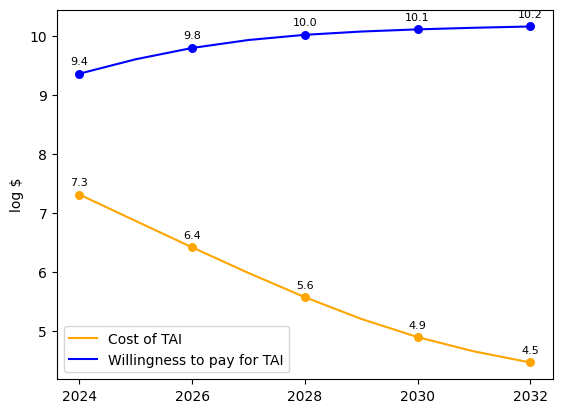

-
-
## SAMPLE RUN 11 ##

In this simulation:
* It takes 24.7 log FLOP (~5.0 septillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~954.7 quadrillion) per 2024$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~11.6 septillion) per 2024$USD.
* We are initially willing to pay 9.2 log 2024$USD (~1.8 billion).
* This doubles every 3.3 year to a max of 0.06281% of GDP (initially ~15.7 billion 2024$USD).
* GDP grows at a rate of 1.025x per year.
---
2024 - TAI takes 24.7 logFLOP which costs 6.7 log 2024$USD to buy vs. WTP at 9.2 (buys 27.2 log FLOP or 27.2 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- integration 

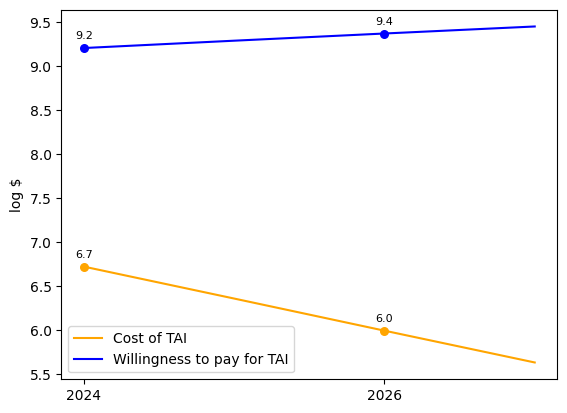

-
-
## SAMPLE RUN 12 ##

In this simulation:
* It takes 44.5 log FLOP (~316.2 billion decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~3.6 quintillion) per 2024$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 25.3 log FLOP (~17.9 septillion) per 2024$USD.
* We are initially willing to pay 8.8 log 2024$USD (~705.4 million).
* This doubles every 1.4 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.023x per year.
---
2024 - TAI takes 44.5 logFLOP which costs 25.9 log 2024$USD to buy vs. WTP at 8.8 (buys 27.4 log FLOP or 27.4 2024-log-eFLOP)
2025 - TAI takes 44.1 logFLOP which costs 25.4 log 2024$USD to buy vs. WTP at 9.0 (buys 27.7 log FLOP or 28.0 2024-log-eFLOP)
2026 - TAI takes 43.7 logFLOP which costs 24.9 log 2024$USD to buy vs. WTP at 9.2 (buys 28.0 log FLOP or 28.7 2024-log-eFLOP)
2027 - TAI takes 43.4 logFLOP which

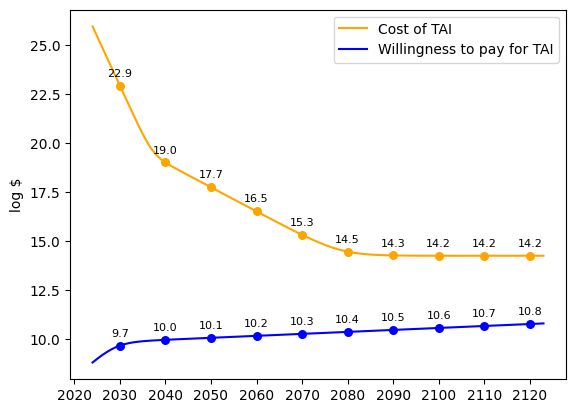

-
-
## SAMPLE RUN 13 ##

In this simulation:
* It takes 37.5 log FLOP (~31.6 thousand decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.6 quintillion) per 2024$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~68.7 sextillion) per 2024$USD.
* We are initially willing to pay 9.0 log 2024$USD (~1.0 billion).
* This doubles every 4.7 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.017x per year.
---
2024 - TAI takes 37.5 logFLOP which costs 19.3 log 2024$USD to buy vs. WTP at 9.0 (buys 27.2 log FLOP or 27.2 2024-log-eFLOP)
2025 - TAI takes 37.2 logFLOP which costs 18.9 log 2024$USD to buy vs. WTP at 9.0 (buys 27.3 log FLOP or 27.6 2024-log-eFLOP)
2026 - TAI takes 37.0 logFLOP which costs 18.5 log 2024$USD to buy vs. WTP at 9.1 (buys 27.5 log FLOP or 28.0 2024-log-eFLOP)
2027 - TAI takes 36.7 logFLOP which c

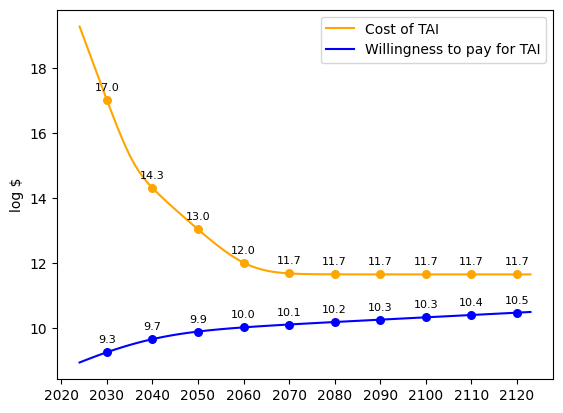

-
-
## SAMPLE RUN 14 ##

In this simulation:
* It takes 47.2 log FLOP (~158.5 trillion decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 6 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~2.9 quintillion) per 2024$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 27.2 log FLOP (~1.8 octillion) per 2024$USD.
* We are initially willing to pay 9.5 log 2024$USD (~3.5 billion).
* This doubles every 3.6 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.018x per year.
---
2024 - TAI takes 47.2 logFLOP which costs 28.7 log 2024$USD to buy vs. WTP at 9.4 (buys 27.8 log FLOP or 27.8 2024-log-eFLOP)
2025 - TAI takes 46.9 logFLOP which costs 28.3 log 2024$USD to buy vs. WTP at 9.4 (buys 28.0 log FLOP or 28.3 2024-log-eFLOP)
2026 - TAI takes 46.6 logFLOP which costs 27.9 log 2024$USD to buy vs. WTP at 9.5 (buys 28.2 log FLOP or 28.8 2024-log-eFLOP)
2027 - TAI takes 46.2 logFLOP which co

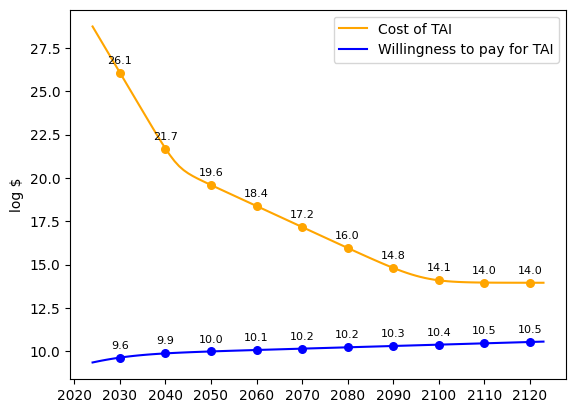

-
-
## SAMPLE RUN 15 ##

In this simulation:
* It takes 31.6 log FLOP (~39.8 nonillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.6 quintillion) per 2024$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~1.5 sextillion) per 2024$USD.
* We are initially willing to pay 8.4 log 2024$USD (~241.6 million).
* This doubles every 5.3 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.015x per year.
---
2024 - TAI takes 31.6 logFLOP which costs 12.9 log 2024$USD to buy vs. WTP at 8.4 (buys 27.0 log FLOP or 27.0 2024-log-eFLOP)
2025 - TAI takes 31.2 logFLOP which costs 12.4 log 2024$USD to buy vs. WTP at 8.4 (buys 27.2 log FLOP or 27.7 2024-log-eFLOP)
2026 - TAI takes 30.7 logFLOP which costs 11.8 log 2024$USD to buy vs. WTP at 8.5 (buys 27.4 log FLOP or 28.3 2024-log-eFLOP)
2027 - TAI takes 30.3 logFLOP which costs 11.

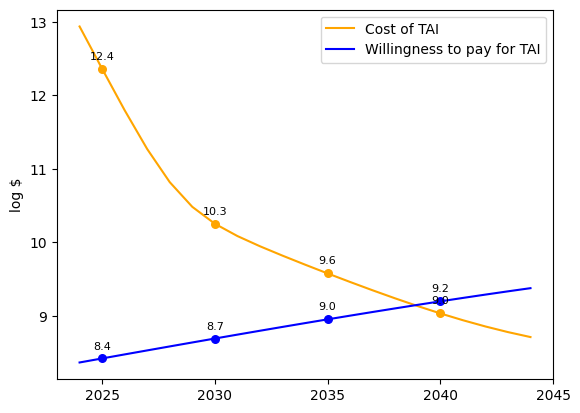

-
-
## SAMPLE RUN 16 ##

In this simulation:
* It takes 27.9 log FLOP (~7.9 octillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.4 log FLOP (~25.2 quintillion) per 2024$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~17.7 sextillion) per 2024$USD.
* We are initially willing to pay 8.6 log 2024$USD (~381.2 million).
* This doubles every 1.1 year to a max of 0.035786% of GDP (initially ~9.0 billion 2024$USD).
* GDP grows at a rate of 1.027x per year.
---
2024 - TAI takes 27.9 logFLOP which costs 8.5 log 2024$USD to buy vs. WTP at 8.6 (buys 28.0 log FLOP or 28.0 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 7 years

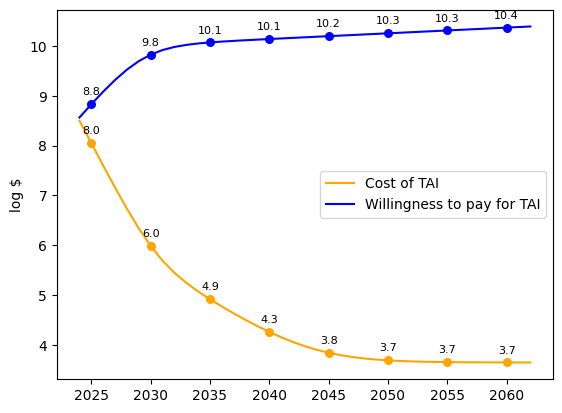

-
-
## SAMPLE RUN 17 ##

In this simulation:
* It takes 30.6 log FLOP (~4.0 nonillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.1 quintillion) per 2024$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~175.5 sextillion) per 2024$USD.
* We are initially willing to pay 8.3 log 2024$USD (~199.0 million).
* This doubles every 11.6 year to a max of 0.311419% of GDP (initially ~78.4 billion 2024$USD).
* GDP grows at a rate of 1.02x per year.
---
2024 - TAI takes 30.6 logFLOP which costs 12.3 log 2024$USD to buy vs. WTP at 8.3 (buys 26.6 log FLOP or 26.6 2024-log-eFLOP)
2025 - TAI takes 30.4 logFLOP which costs 11.9 log 2024$USD to buy vs. WTP at 8.3 (buys 26.8 log FLOP or 27.0 2024-log-eFLOP)
2026 - TAI takes 30.1 logFLOP which costs 11.6 log 2024$USD to buy vs. WTP at 8.3 (buys 26.9 log FLOP or 27.4 2024-log-eFLOP)
2027 - TAI takes 29.9 logFLOP which cost

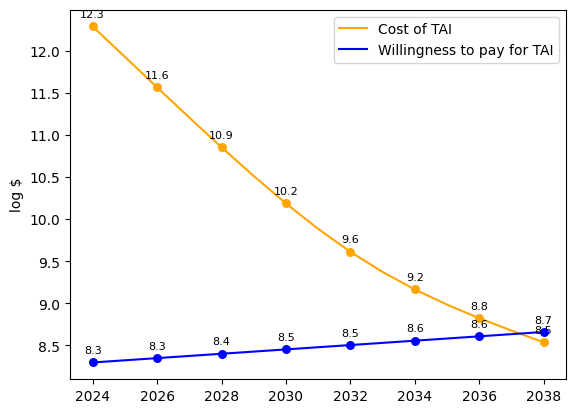

-
-
## SAMPLE RUN 18 ##

In this simulation:
* It takes 30.9 log FLOP (~7.9 nonillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~2.9 quintillion) per 2024$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 26.4 log FLOP (~237.5 septillion) per 2024$USD.
* We are initially willing to pay 8.7 log 2024$USD (~464.4 million).
* This doubles every 2.9 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.026x per year.
---
2024 - TAI takes 30.9 logFLOP which costs 12.4 log 2024$USD to buy vs. WTP at 8.6 (buys 27.1 log FLOP or 27.1 2024-log-eFLOP)
2025 - TAI takes 30.6 logFLOP which costs 12.1 log 2024$USD to buy vs. WTP at 8.7 (buys 27.3 log FLOP or 27.6 2024-log-eFLOP)
2026 - TAI takes 30.4 logFLOP which costs 11.7 log 2024$USD to buy vs. WTP at 8.8 (buys 27.5 log FLOP or 28.1 2024-log-eFLOP)
2027 - TAI takes 30.1 logFLOP which costs 11

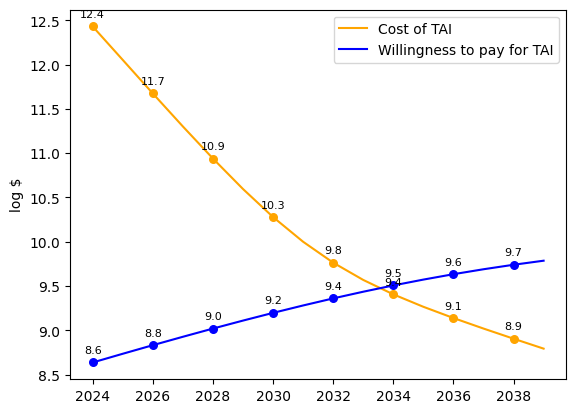

-
-
## SAMPLE RUN 19 ##

In this simulation:
* It takes 27.8 log FLOP (~6.3 octillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~9.2 quintillion) per 2024$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~137.5 sextillion) per 2024$USD.
* We are initially willing to pay 8.7 log 2024$USD (~495.3 million).
* This doubles every 3.5 year to a max of 0.16758% of GDP (initially ~42.0 billion 2024$USD).
* GDP grows at a rate of 1.025x per year.
---
2024 - TAI takes 27.8 logFLOP which costs 8.8 log 2024$USD to buy vs. WTP at 8.7 (buys 27.7 log FLOP or 27.7 2024-log-eFLOP)
2025 - TAI takes 27.4 logFLOP which costs 8.3 log 2024$USD to buy vs. WTP at 8.8 (buys 27.9 log FLOP or 28.2 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3218 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling i

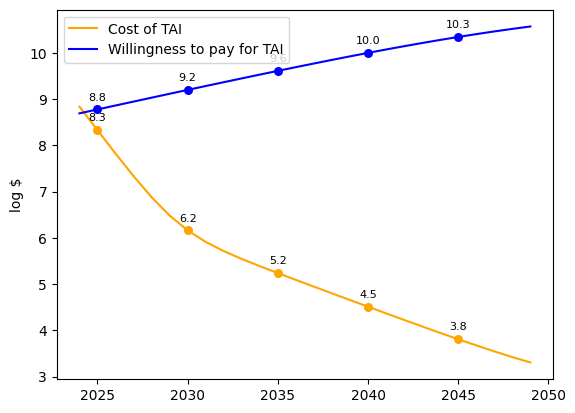

-
-
## SAMPLE RUN 20 ##

In this simulation:
* It takes 30.7 log FLOP (~5.0 nonillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.2 quintillion) per 2024$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~1.1 septillion) per 2024$USD.
* We are initially willing to pay 8.6 log 2024$USD (~384.3 million).
* This doubles every 3.1 year to a max of 0.044528% of GDP (initially ~11.1 billion 2024$USD).
* GDP grows at a rate of 1.018x per year.
---
2024 - TAI takes 30.7 logFLOP which costs 12.2 log 2024$USD to buy vs. WTP at 8.6 (buys 27.1 log FLOP or 27.1 2024-log-eFLOP)
2025 - TAI takes 30.5 logFLOP which costs 11.9 log 2024$USD to buy vs. WTP at 8.7 (buys 27.3 log FLOP or 27.5 2024-log-eFLOP)
2026 - TAI takes 30.3 logFLOP which costs 11.5 log 2024$USD to buy vs. WTP at 8.8 (buys 27.5 log FLOP or 27.9 2024-log-eFLOP)
2027 - TAI takes 30.1 logFLOP which costs 

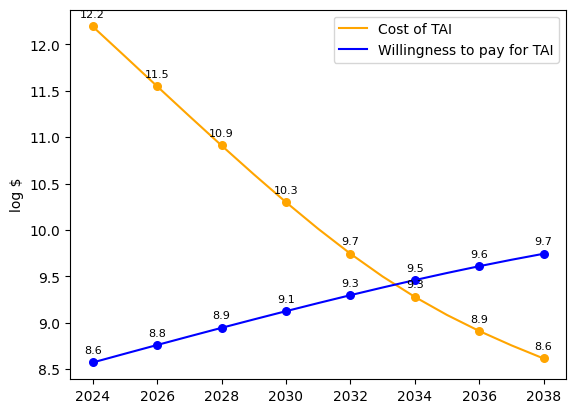

-
-
## SAMPLE RUN 21 ##

In this simulation:
* It takes 28.7 log FLOP (~50.1 octillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.5 quintillion) per 2024$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~14.3 sextillion) per 2024$USD.
* We are initially willing to pay 8.4 log 2024$USD (~241.5 million).
* This doubles every 9.1 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.036x per year.
---
2024 - TAI takes 28.7 logFLOP which costs 9.9 log 2024$USD to buy vs. WTP at 8.4 (buys 27.2 log FLOP or 27.2 2024-log-eFLOP)
2025 - TAI takes 28.5 logFLOP which costs 9.6 log 2024$USD to buy vs. WTP at 8.4 (buys 27.4 log FLOP or 27.5 2024-log-eFLOP)
2026 - TAI takes 28.3 logFLOP which costs 9.2 log 2024$USD to buy vs. WTP at 8.4 (buys 27.5 log FLOP or 27.9 2024-log-eFLOP)
2027 - TAI takes 28.1 logFLOP which costs 8.9 l

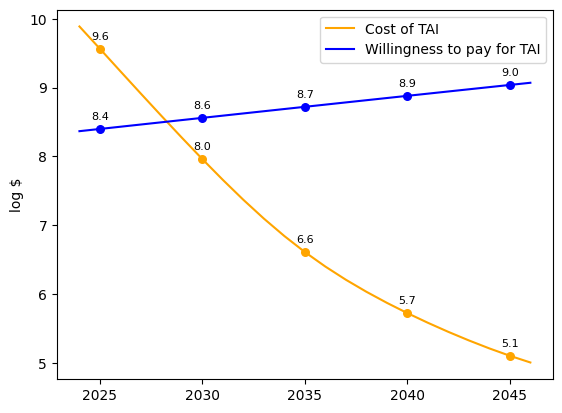

-
-
## SAMPLE RUN 22 ##

In this simulation:
* It takes 37.0 log FLOP (~10.0 thousand decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~17.7 quintillion) per 2024$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~3.8 septillion) per 2024$USD.
* We are initially willing to pay 8.4 log 2024$USD (~241.6 million).
* This doubles every 0.9 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.032x per year.
---
2024 - TAI takes 37.0 logFLOP which costs 17.8 log 2024$USD to buy vs. WTP at 8.4 (buys 27.6 log FLOP or 27.6 2024-log-eFLOP)
2025 - TAI takes 36.6 logFLOP which costs 17.3 log 2024$USD to buy vs. WTP at 8.7 (buys 28.0 log FLOP or 28.4 2024-log-eFLOP)
2026 - TAI takes 36.3 logFLOP which costs 16.8 log 2024$USD to buy vs. WTP at 9.0 (buys 28.5 log FLOP or 29.2 2024-log-eFLOP)
2027 - TAI takes 35.9 logFLOP which

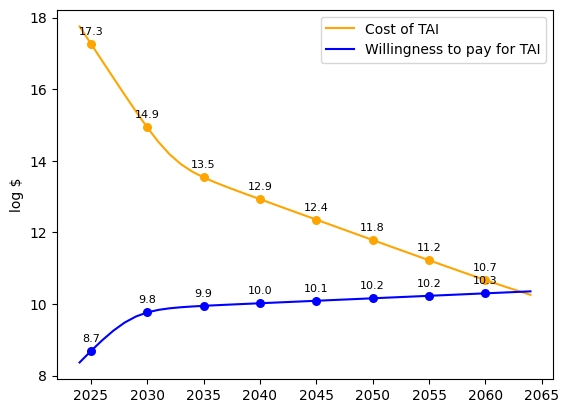

-
-
## SAMPLE RUN 23 ##

In this simulation:
* It takes 38.0 log FLOP (~100.0 thousand decillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.2 quintillion) per 2024$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 25.7 log FLOP (~50.3 septillion) per 2024$USD.
* We are initially willing to pay 8.7 log 2024$USD (~463.6 million).
* This doubles every 1.7 year to a max of 0.025% of GDP (initially ~6.2 billion 2024$USD).
* GDP grows at a rate of 1.038x per year.
---
2024 - TAI takes 38.0 logFLOP which costs 19.9 log 2024$USD to buy vs. WTP at 8.6 (buys 26.7 log FLOP or 26.7 2024-log-eFLOP)
2025 - TAI takes 37.8 logFLOP which costs 19.6 log 2024$USD to buy vs. WTP at 8.8 (buys 27.0 log FLOP or 27.2 2024-log-eFLOP)
2026 - TAI takes 37.7 logFLOP which costs 19.3 log 2024$USD to buy vs. WTP at 9.0 (buys 27.3 log FLOP or 27.6 2024-log-eFLOP)
2027 - TAI takes 37.5 logFLOP whic

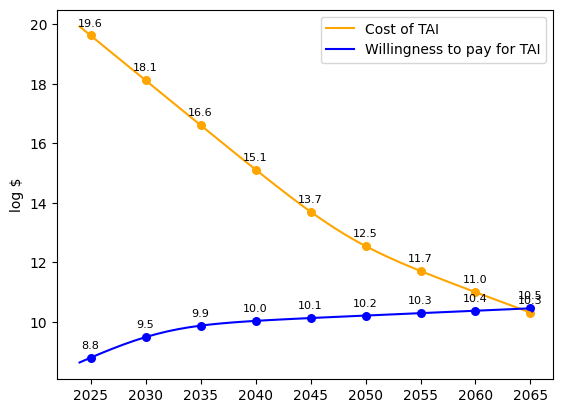

-
-
## SAMPLE RUN 24 ##

In this simulation:
* It takes 29.2 log FLOP (~158.5 octillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~949.1 quadrillion) per 2024$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~700.9 sextillion) per 2024$USD.
* We are initially willing to pay 8.5 log 2024$USD (~301.8 million).
* This doubles every 5.1 year to a max of 0.026596% of GDP (initially ~6.6 billion 2024$USD).
* GDP grows at a rate of 1.019x per year.
---
2024 - TAI takes 29.2 logFLOP which costs 11.2 log 2024$USD to buy vs. WTP at 8.5 (buys 26.4 log FLOP or 26.4 2024-log-eFLOP)
2025 - TAI takes 29.0 logFLOP which costs 10.9 log 2024$USD to buy vs. WTP at 8.5 (buys 26.6 log FLOP or 26.8 2024-log-eFLOP)
2026 - TAI takes 28.8 logFLOP which costs 10.6 log 2024$USD to buy vs. WTP at 8.6 (buys 26.8 log FLOP or 27.2 2024-log-eFLOP)
2027 - TAI takes 28.5 logFLOP which c

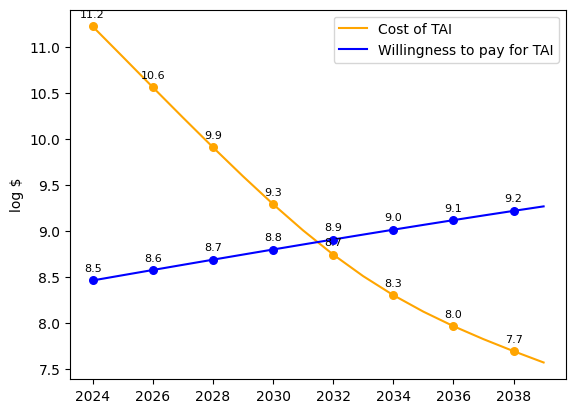

-
-
## SAMPLE RUN 25 ##

In this simulation:
* It takes 28.8 log FLOP (~63.1 octillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.7 quintillion) per 2024$USD.
* Every 1.9 years they get 2x cheaper, to a maximum of 25.7 log FLOP (~52.6 septillion) per 2024$USD.
* We are initially willing to pay 9.4 log 2024$USD (~2.4 billion).
* This doubles every 8.6 year to a max of 0.042653% of GDP (initially ~10.8 billion 2024$USD).
* GDP grows at a rate of 1.034x per year.
---
2024 - TAI takes 28.8 logFLOP which costs 10.6 log 2024$USD to buy vs. WTP at 9.3 (buys 27.5 log FLOP or 27.5 2024-log-eFLOP)
2025 - TAI takes 28.6 logFLOP which costs 10.2 log 2024$USD to buy vs. WTP at 9.3 (buys 27.7 log FLOP or 27.9 2024-log-eFLOP)
2026 - TAI takes 28.4 logFLOP which costs 9.8 log 2024$USD to buy vs. WTP at 9.4 (buys 27.9 log FLOP or 28.3 2024-log-eFLOP)
2027 - TAI takes 28.2 logFLOP which costs 9

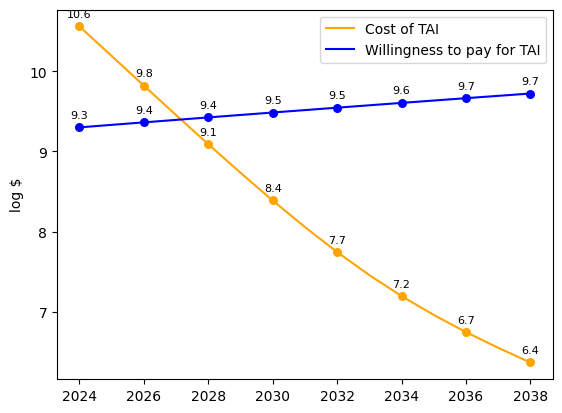

-
-
## SAMPLE RUN 26 ##

In this simulation:
* It takes 39.6 log FLOP (~4.0 million decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~681.0 quadrillion) per 2024$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 25.2 log FLOP (~14.2 septillion) per 2024$USD.
* We are initially willing to pay 9.6 log 2024$USD (~4.4 billion).
* This doubles every 2.1 year to a max of 0.059793% of GDP (initially ~15.1 billion 2024$USD).
* GDP grows at a rate of 1.029x per year.
---
2024 - TAI takes 39.6 logFLOP which costs 21.8 log 2024$USD to buy vs. WTP at 9.5 (buys 27.4 log FLOP or 27.4 2024-log-eFLOP)
2025 - TAI takes 39.2 logFLOP which costs 21.2 log 2024$USD to buy vs. WTP at 9.6 (buys 27.6 log FLOP or 28.0 2024-log-eFLOP)
2026 - TAI takes 38.7 logFLOP which costs 20.7 log 2024$USD to buy vs. WTP at 9.7 (buys 27.8 log FLOP or 28.7 2024-log-eFLOP)
2027 - TAI takes 38.3 logFLOP whi

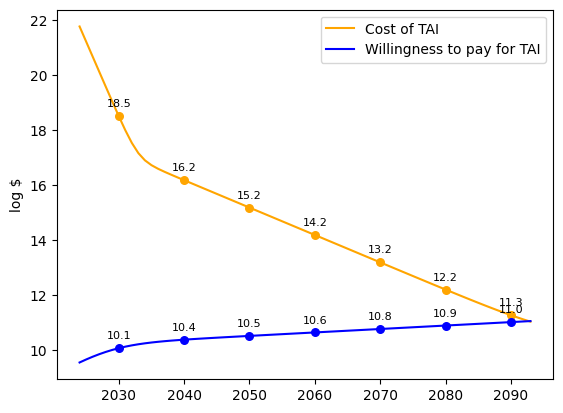

-
-
## SAMPLE RUN 27 ##

In this simulation:
* It takes 27.9 log FLOP (~7.9 octillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~14.6 quintillion) per 2024$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~21.5 sextillion) per 2024$USD.
* We are initially willing to pay 8.3 log 2024$USD (~193.4 million).
* This doubles every 5.7 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.021x per year.
---
2024 - TAI takes 27.9 logFLOP which costs 8.7 log 2024$USD to buy vs. WTP at 8.3 (buys 27.4 log FLOP or 27.4 2024-log-eFLOP)
2025 - TAI takes 27.7 logFLOP which costs 8.4 log 2024$USD to buy vs. WTP at 8.3 (buys 27.6 log FLOP or 27.8 2024-log-eFLOP)
2026 - TAI takes 27.5 logFLOP which costs 8.1 log 2024$USD to buy vs. WTP at 8.4 (buys 27.8 log FLOP or 28.2 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3038 -> No

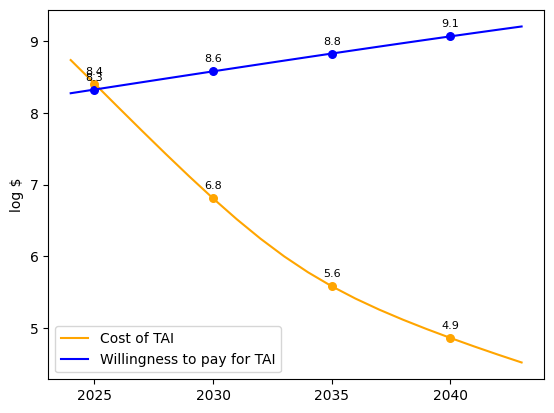

-
-
## SAMPLE RUN 28 ##

In this simulation:
* It takes 26.0 log FLOP (~100.0 septillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.1 quintillion) per 2024$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~11.1 sextillion) per 2024$USD.
* We are initially willing to pay 10.3 log 2024$USD (~17.9 billion).
* This doubles every 3.5 year to a max of 0.677228% of GDP (initially ~170.0 billion 2024$USD).
* GDP grows at a rate of 1.028x per year.
---
2024 - TAI takes 26.0 logFLOP which costs 7.5 log 2024$USD to buy vs. WTP at 10.2 (buys 28.7 log FLOP or 28.7 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 9 

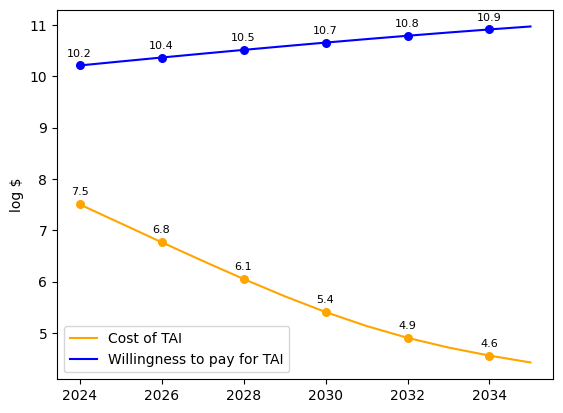

-
-
## SAMPLE RUN 29 ##

In this simulation:
* It takes 25.9 log FLOP (~79.4 septillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~9.9 quintillion) per 2024$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 25.2 log FLOP (~14.7 septillion) per 2024$USD.
* We are initially willing to pay 8.8 log 2024$USD (~705.4 million).
* This doubles every 4.9 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.019x per year.
---
2024 - TAI takes 25.9 logFLOP which costs 6.9 log 2024$USD to buy vs. WTP at 8.8 (buys 27.8 log FLOP or 27.8 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 6 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- 

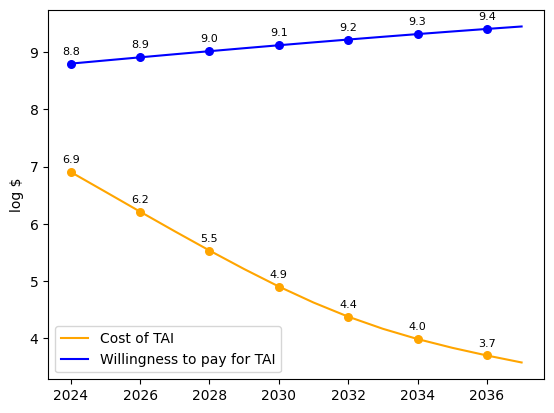

-
-
## SAMPLE RUN 30 ##

In this simulation:
* It takes 28.2 log FLOP (~15.8 octillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.7 quintillion) per 2024$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~1.7 sextillion) per 2024$USD.
* We are initially willing to pay 8.6 log 2024$USD (~387.1 million).
* This doubles every 4.4 year to a max of 0.056553% of GDP (initially ~14.0 billion 2024$USD).
* GDP grows at a rate of 1.021x per year.
---
2024 - TAI takes 28.2 logFLOP which costs 9.8 log 2024$USD to buy vs. WTP at 8.6 (buys 27.0 log FLOP or 27.0 2024-log-eFLOP)
2025 - TAI takes 28.0 logFLOP which costs 9.4 log 2024$USD to buy vs. WTP at 8.6 (buys 27.2 log FLOP or 27.4 2024-log-eFLOP)
2026 - TAI takes 27.7 logFLOP which costs 9.0 log 2024$USD to buy vs. WTP at 8.7 (buys 27.4 log FLOP or 27.9 2024-log-eFLOP)
2027 - TAI takes 27.5 logFLOP which costs 8.

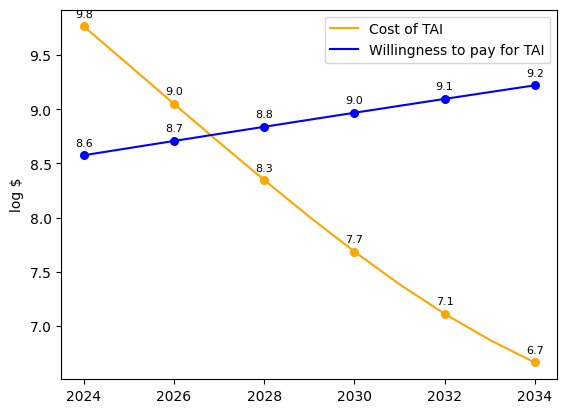

-
-
## SAMPLE RUN 31 ##

In this simulation:
* It takes 28.3 log FLOP (~20.0 octillion) for transformative capabilities.
* Every 2.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.1 quintillion) per 2024$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~5.9 septillion) per 2024$USD.
* We are initially willing to pay 9.9 log 2024$USD (~7.9 billion).
* This doubles every 2.0 year to a max of 0.146655% of GDP (initially ~36.9 billion 2024$USD).
* GDP grows at a rate of 1.022x per year.
---
2024 - TAI takes 28.3 logFLOP which costs 9.7 log 2024$USD to buy vs. WTP at 9.8 (buys 28.4 log FLOP or 28.4 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 1 years (total delay 1 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 5 years)


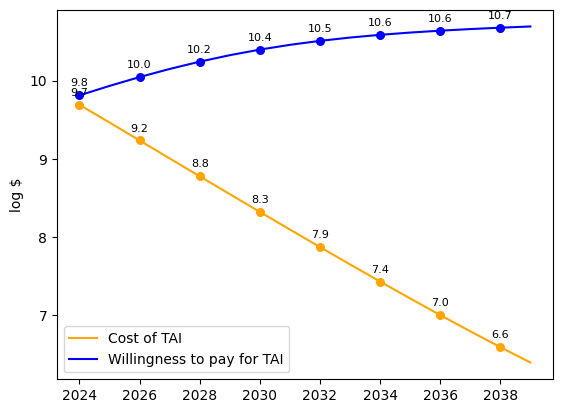

-
-
## SAMPLE RUN 32 ##

In this simulation:
* It takes 27.6 log FLOP (~4.0 octillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.5 log FLOP (~305.4 quadrillion) per 2024$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2.2 septillion) per 2024$USD.
* We are initially willing to pay 8.8 log 2024$USD (~598.6 million).
* This doubles every 4.8 year to a max of 0.046512% of GDP (initially ~11.7 billion 2024$USD).
* GDP grows at a rate of 1.034x per year.
---
2024 - TAI takes 27.6 logFLOP which costs 10.1 log 2024$USD to buy vs. WTP at 8.8 (buys 26.2 log FLOP or 26.2 2024-log-eFLOP)
2025 - TAI takes 27.4 logFLOP which costs 9.8 log 2024$USD to buy vs. WTP at 8.8 (buys 26.4 log FLOP or 26.7 2024-log-eFLOP)
2026 - TAI takes 27.2 logFLOP which costs 9.4 log 2024$USD to buy vs. WTP at 8.9 (buys 26.6 log FLOP or 27.1 2024-log-eFLOP)
2027 - TAI takes 26.9 logFLOP which costs 

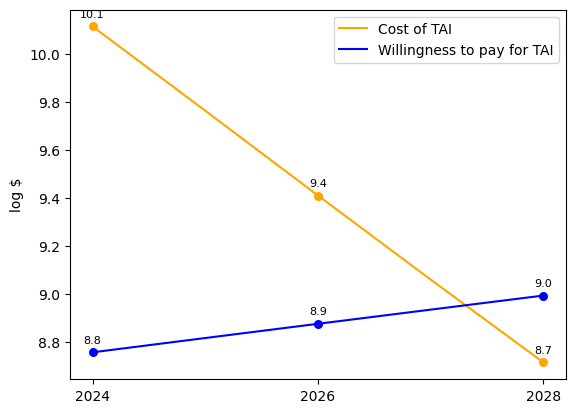

-
-
## SAMPLE RUN 33 ##

In this simulation:
* It takes 33.7 log FLOP (~5.0 decillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.4 log FLOP (~23.2 quintillion) per 2024$USD.
* Every 1.9 years they get 2x cheaper, to a maximum of 25.7 log FLOP (~51.6 septillion) per 2024$USD.
* We are initially willing to pay 9.2 log 2024$USD (~1.7 billion).
* This doubles every 4.6 year to a max of 0.047506% of GDP (initially ~12.0 billion 2024$USD).
* GDP grows at a rate of 1.039x per year.
---
2024 - TAI takes 33.7 logFLOP which costs 14.3 log 2024$USD to buy vs. WTP at 9.2 (buys 28.5 log FLOP or 28.5 2024-log-eFLOP)
2025 - TAI takes 33.5 logFLOP which costs 14.0 log 2024$USD to buy vs. WTP at 9.2 (buys 28.8 log FLOP or 28.9 2024-log-eFLOP)
2026 - TAI takes 33.4 logFLOP which costs 13.7 log 2024$USD to buy vs. WTP at 9.3 (buys 29.0 log FLOP or 29.3 2024-log-eFLOP)
2027 - TAI takes 33.2 logFLOP which costs 

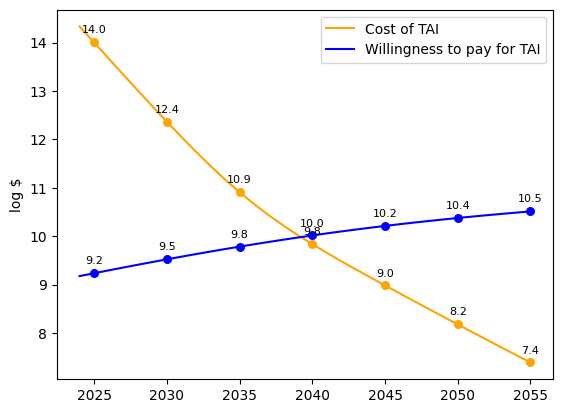

-
-
## SAMPLE RUN 34 ##

In this simulation:
* It takes 26.0 log FLOP (~100.0 septillion) for transformative capabilities.
* Every 2.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~11.9 quintillion) per 2024$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~106.8 sextillion) per 2024$USD.
* We are initially willing to pay 9.3 log 2024$USD (~1.8 billion).
* This doubles every 1.2 year to a max of 0.092748% of GDP (initially ~23.3 billion 2024$USD).
* GDP grows at a rate of 1.016x per year.
---
2024 - TAI takes 26.0 logFLOP which costs 6.9 log 2024$USD to buy vs. WTP at 9.2 (buys 28.3 log FLOP or 28.3 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 4 ye

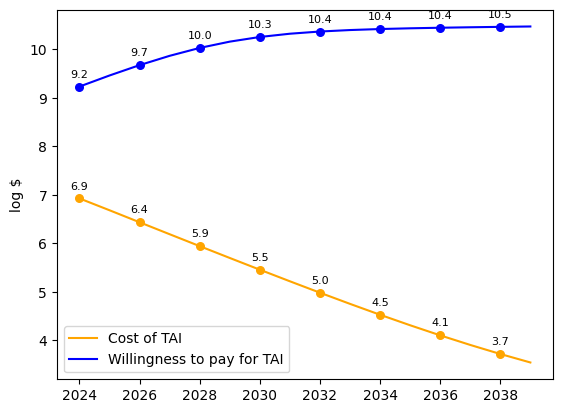

-
-
## SAMPLE RUN 35 ##

In this simulation:
* It takes 41.0 log FLOP (~100.0 million decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.6 quintillion) per 2024$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 25.3 log FLOP (~21.8 septillion) per 2024$USD.
* We are initially willing to pay 9.3 log 2024$USD (~1.9 billion).
* This doubles every 2.0 year to a max of 0.029711% of GDP (initially ~7.4 billion 2024$USD).
* GDP grows at a rate of 1.021x per year.
---
2024 - TAI takes 41.0 logFLOP which costs 22.3 log 2024$USD to buy vs. WTP at 9.2 (buys 27.8 log FLOP or 27.8 2024-log-eFLOP)
2025 - TAI takes 40.6 logFLOP which costs 21.8 log 2024$USD to buy vs. WTP at 9.3 (buys 28.1 log FLOP or 28.5 2024-log-eFLOP)
2026 - TAI takes 40.1 logFLOP which costs 21.2 log 2024$USD to buy vs. WTP at 9.4 (buys 28.4 log FLOP or 29.2 2024-log-eFLOP)
2027 - TAI takes 39.7 logFLOP whic

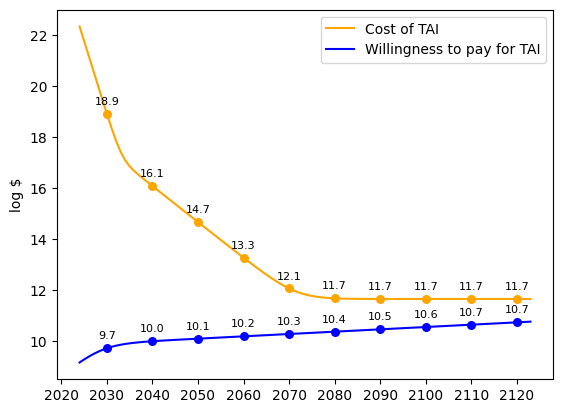

-
-
## SAMPLE RUN 36 ##

In this simulation:
* It takes 38.3 log FLOP (~199.5 thousand decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.5 quintillion) per 2024$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10.8 sextillion) per 2024$USD.
* We are initially willing to pay 9.0 log 2024$USD (~1.1 billion).
* This doubles every 1.6 year to a max of 0.026534% of GDP (initially ~6.7 billion 2024$USD).
* GDP grows at a rate of 1.027x per year.
---
2024 - TAI takes 38.3 logFLOP which costs 19.5 log 2024$USD to buy vs. WTP at 9.0 (buys 27.8 log FLOP or 27.8 2024-log-eFLOP)
2025 - TAI takes 37.9 logFLOP which costs 19.0 log 2024$USD to buy vs. WTP at 9.1 (buys 28.1 log FLOP or 28.4 2024-log-eFLOP)
2026 - TAI takes 37.5 logFLOP which costs 18.5 log 2024$USD to buy vs. WTP at 9.3 (buys 28.3 log FLOP or 29.1 2024-log-eFLOP)
2027 - TAI takes 37.1 logFLOP whi

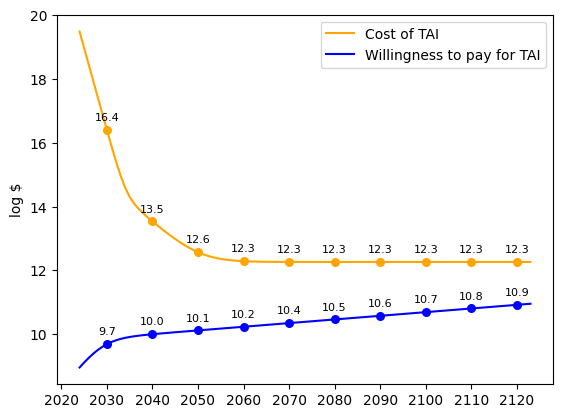

-
-
## SAMPLE RUN 37 ##

In this simulation:
* It takes 27.8 log FLOP (~6.3 octillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.5 quintillion) per 2024$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~414.1 sextillion) per 2024$USD.
* We are initially willing to pay 8.0 log 2024$USD (~98.4 million).
* This doubles every 2.8 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.02x per year.
---
2024 - TAI takes 27.8 logFLOP which costs 9.6 log 2024$USD to buy vs. WTP at 8.0 (buys 26.2 log FLOP or 26.2 2024-log-eFLOP)
2025 - TAI takes 27.5 logFLOP which costs 9.2 log 2024$USD to buy vs. WTP at 8.1 (buys 26.4 log FLOP or 26.7 2024-log-eFLOP)
2026 - TAI takes 27.2 logFLOP which costs 8.8 log 2024$USD to buy vs. WTP at 8.2 (buys 26.6 log FLOP or 27.2 2024-log-eFLOP)
2027 - TAI takes 26.9 logFLOP which costs 8.4 log

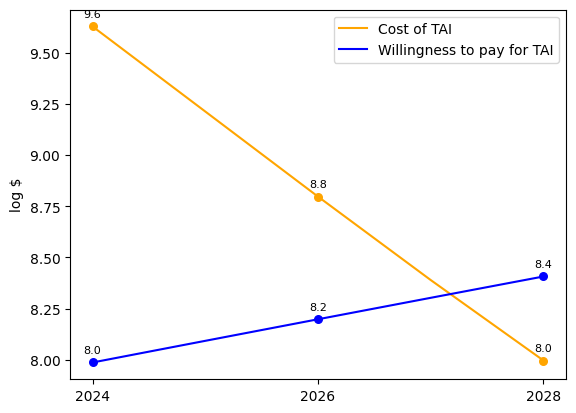

-
-
## SAMPLE RUN 38 ##

In this simulation:
* It takes 38.1 log FLOP (~125.9 thousand decillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 19.5 log FLOP (~29.9 quintillion) per 2024$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2.2 septillion) per 2024$USD.
* We are initially willing to pay 9.0 log 2024$USD (~1.0 billion).
* This doubles every 1.1 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.034x per year.
---
2024 - TAI takes 38.1 logFLOP which costs 18.6 log 2024$USD to buy vs. WTP at 9.0 (buys 28.4 log FLOP or 28.4 2024-log-eFLOP)
2025 - TAI takes 37.9 logFLOP which costs 18.3 log 2024$USD to buy vs. WTP at 9.2 (buys 28.8 log FLOP or 29.0 2024-log-eFLOP)
2026 - TAI takes 37.7 logFLOP which costs 18.0 log 2024$USD to buy vs. WTP at 9.4 (buys 29.1 log FLOP or 29.5 2024-log-eFLOP)
2027 - TAI takes 37.5 logFLOP which 

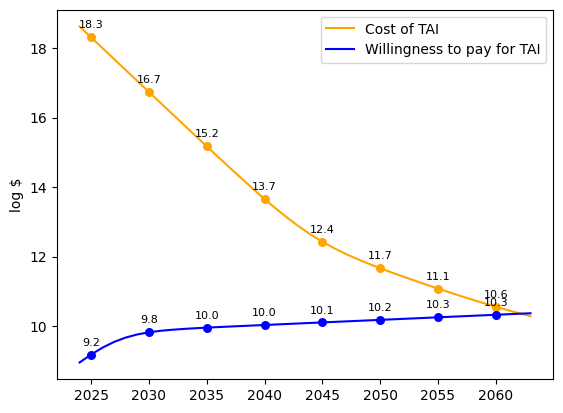

-
-
## SAMPLE RUN 39 ##

In this simulation:
* It takes 38.4 log FLOP (~251.2 thousand decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 19.3 log FLOP (~17.9 quintillion) per 2024$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4.3 sextillion) per 2024$USD.
* We are initially willing to pay 9.6 log 2024$USD (~4.2 billion).
* This doubles every 3.1 year to a max of 0.025% of GDP (initially ~6.2 billion 2024$USD).
* GDP grows at a rate of 1.016x per year.
---
2024 - TAI takes 38.4 logFLOP which costs 19.1 log 2024$USD to buy vs. WTP at 9.4 (buys 28.6 log FLOP or 28.7 2024-log-eFLOP)
2025 - TAI takes 38.1 logFLOP which costs 18.7 log 2024$USD to buy vs. WTP at 9.5 (buys 28.8 log FLOP or 29.2 2024-log-eFLOP)
2026 - TAI takes 37.7 logFLOP which costs 18.2 log 2024$USD to buy vs. WTP at 9.5 (buys 29.0 log FLOP or 29.7 2024-log-eFLOP)
2027 - TAI takes 37.4 logFLOP which 

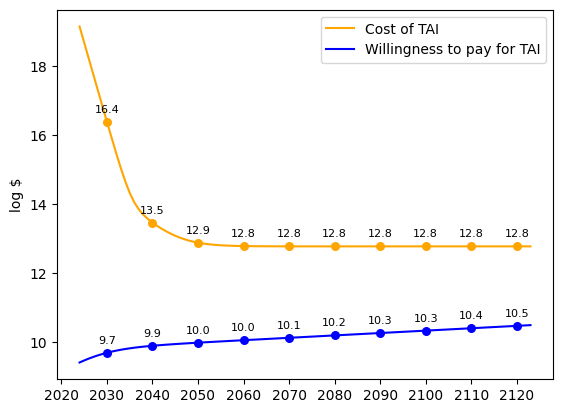

-
-
## SAMPLE RUN 40 ##

In this simulation:
* It takes 29.5 log FLOP (~316.2 octillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.4 quintillion) per 2024$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~671.4 sextillion) per 2024$USD.
* We are initially willing to pay 8.6 log 2024$USD (~389.2 million).
* This doubles every 0.9 year to a max of 0.069298% of GDP (initially ~17.4 billion 2024$USD).
* GDP grows at a rate of 1.022x per year.
---
2024 - TAI takes 29.5 logFLOP which costs 11.4 log 2024$USD to buy vs. WTP at 8.6 (buys 26.7 log FLOP or 26.7 2024-log-eFLOP)
2025 - TAI takes 29.2 logFLOP which costs 11.0 log 2024$USD to buy vs. WTP at 8.9 (buys 27.2 log FLOP or 27.4 2024-log-eFLOP)
2026 - TAI takes 29.0 logFLOP which costs 10.6 log 2024$USD to buy vs. WTP at 9.2 (buys 27.6 log FLOP or 28.1 2024-log-eFLOP)
2027 - TAI takes 28.7 logFLOP which co

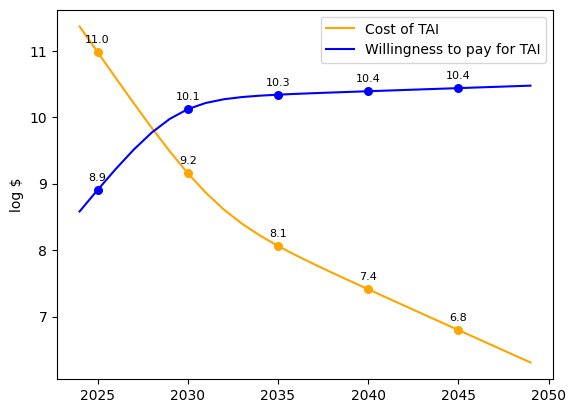

-
-
## SAMPLE RUN 41 ##

In this simulation:
* It takes 39.1 log FLOP (~1.3 million decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 19.4 log FLOP (~25.2 quintillion) per 2024$USD.
* Every 1.9 years they get 2x cheaper, to a maximum of 20.6 log FLOP (~385.4 quintillion) per 2024$USD.
* We are initially willing to pay 9.2 log 2024$USD (~1.5 billion).
* This doubles every 3.1 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.032x per year.
---
2024 - TAI takes 39.1 logFLOP which costs 19.7 log 2024$USD to buy vs. WTP at 9.1 (buys 28.5 log FLOP or 28.5 2024-log-eFLOP)
2025 - TAI takes 38.7 logFLOP which costs 19.2 log 2024$USD to buy vs. WTP at 9.2 (buys 28.7 log FLOP or 29.1 2024-log-eFLOP)
2026 - TAI takes 38.3 logFLOP which costs 18.6 log 2024$USD to buy vs. WTP at 9.2 (buys 28.9 log FLOP or 29.8 2024-log-eFLOP)
2027 - TAI takes 37.9 logFLOP which 

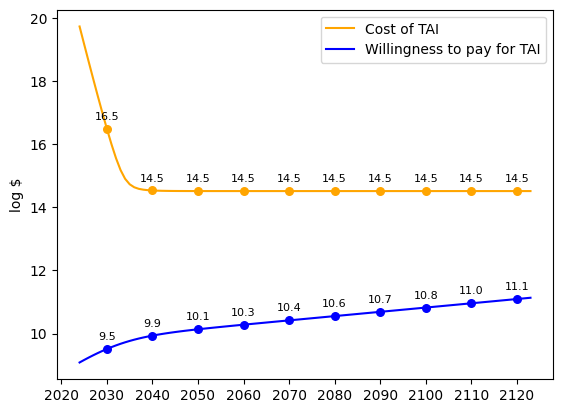

-
-
## SAMPLE RUN 42 ##

In this simulation:
* It takes 32.3 log FLOP (~199.5 nonillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.2 quintillion) per 2024$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~751.5 sextillion) per 2024$USD.
* We are initially willing to pay 9.5 log 2024$USD (~2.9 billion).
* This doubles every 4.1 year to a max of 0.147216% of GDP (initially ~36.8 billion 2024$USD).
* GDP grows at a rate of 1.022x per year.
---
2024 - TAI takes 32.3 logFLOP which costs 13.6 log 2024$USD to buy vs. WTP at 9.4 (buys 28.1 log FLOP or 28.1 2024-log-eFLOP)
2025 - TAI takes 32.1 logFLOP which costs 13.2 log 2024$USD to buy vs. WTP at 9.5 (buys 28.4 log FLOP or 28.6 2024-log-eFLOP)
2026 - TAI takes 31.8 logFLOP which costs 12.8 log 2024$USD to buy vs. WTP at 9.6 (buys 28.6 log FLOP or 29.1 2024-log-eFLOP)
2027 - TAI takes 31.6 logFLOP which cost

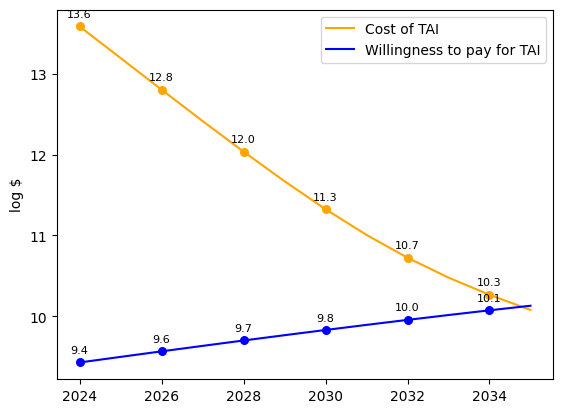

-
-
## SAMPLE RUN 43 ##

In this simulation:
* It takes 26.8 log FLOP (~631.0 septillion) for transformative capabilities.
* Every 2.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.0 quintillion) per 2024$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~96.4 sextillion) per 2024$USD.
* We are initially willing to pay 8.8 log 2024$USD (~705.2 million).
* This doubles every 4.9 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.016x per year.
---
2024 - TAI takes 26.8 logFLOP which costs 7.9 log 2024$USD to buy vs. WTP at 8.8 (buys 27.7 log FLOP or 27.7 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 4 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- --

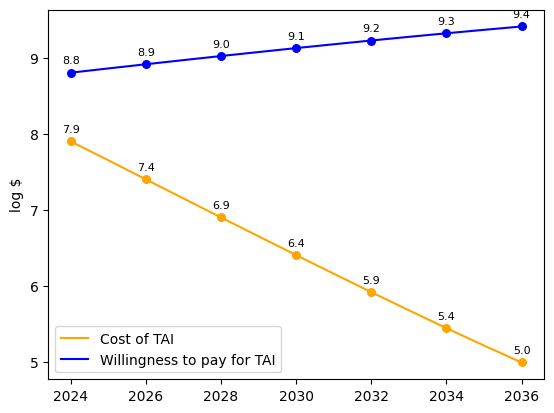

-
-
## SAMPLE RUN 44 ##

In this simulation:
* It takes 29.9 log FLOP (~794.3 octillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.5 quintillion) per 2024$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~53.3 sextillion) per 2024$USD.
* We are initially willing to pay 8.5 log 2024$USD (~303.0 million).
* This doubles every 3.6 year to a max of 0.028982% of GDP (initially ~7.2 billion 2024$USD).
* GDP grows at a rate of 1.016x per year.
---
2024 - TAI takes 29.9 logFLOP which costs 11.7 log 2024$USD to buy vs. WTP at 8.5 (buys 26.6 log FLOP or 26.6 2024-log-eFLOP)
2025 - TAI takes 29.7 logFLOP which costs 11.4 log 2024$USD to buy vs. WTP at 8.5 (buys 26.8 log FLOP or 27.0 2024-log-eFLOP)
2026 - TAI takes 29.5 logFLOP which costs 11.1 log 2024$USD to buy vs. WTP at 8.6 (buys 27.0 log FLOP or 27.4 2024-log-eFLOP)
2027 - TAI takes 29.4 logFLOP which cost

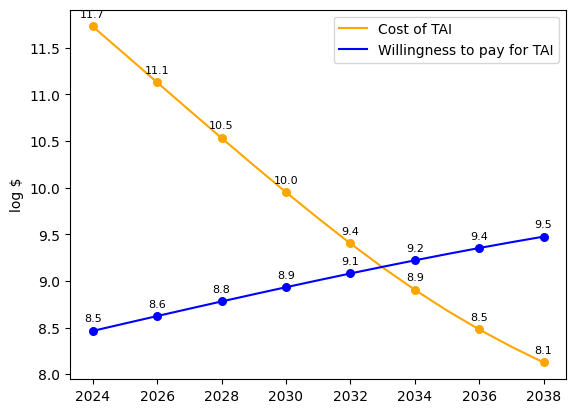

-
-
## SAMPLE RUN 45 ##

In this simulation:
* It takes 26.8 log FLOP (~631.0 septillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.5 quintillion) per 2024$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.5 septillion) per 2024$USD.
* We are initially willing to pay 8.5 log 2024$USD (~315.8 million).
* This doubles every 2.1 year to a max of 0.832367% of GDP (initially ~210.1 billion 2024$USD).
* GDP grows at a rate of 1.015x per year.
---
2024 - TAI takes 26.8 logFLOP which costs 8.3 log 2024$USD to buy vs. WTP at 8.5 (buys 27.0 log FLOP or 27.0 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- robotics p_nonscaling_issue p=0.3 ->

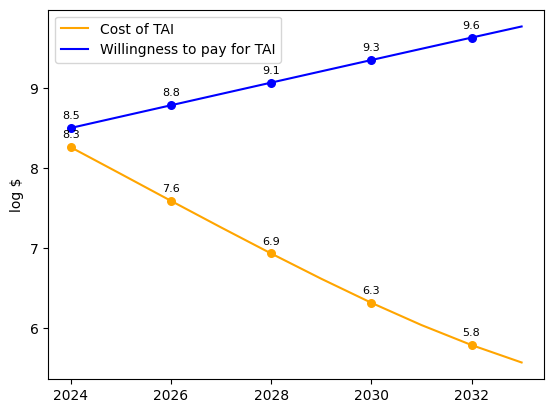

-
-
## SAMPLE RUN 46 ##

In this simulation:
* It takes 27.0 log FLOP (~1.0 octillion) for transformative capabilities.
* Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.2 quintillion) per 2024$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 25.6 log FLOP (~38.4 septillion) per 2024$USD.
* We are initially willing to pay 8.5 log 2024$USD (~314.7 million).
* This doubles every 2.0 year to a max of 0.258371% of GDP (initially ~65.2 billion 2024$USD).
* GDP grows at a rate of 1.016x per year.
---
2024 - TAI takes 27.0 logFLOP which costs 8.4 log 2024$USD to buy vs. WTP at 8.5 (buys 27.1 log FLOP or 27.1 2024-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 4 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -

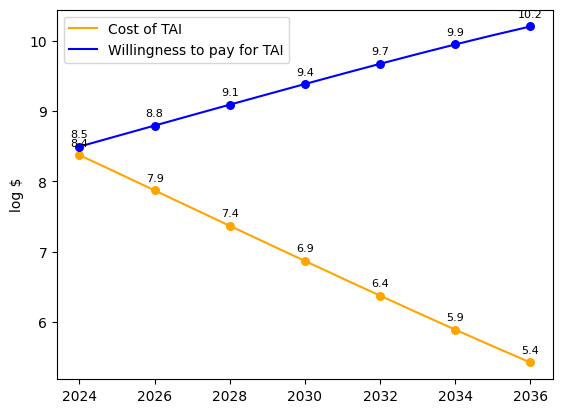

-
-
## SAMPLE RUN 47 ##

In this simulation:
* It takes 30.6 log FLOP (~4.0 nonillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~13.4 quintillion) per 2024$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~3.0 septillion) per 2024$USD.
* We are initially willing to pay 9.4 log 2024$USD (~2.4 billion).
* This doubles every 2.8 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.028x per year.
---
2024 - TAI takes 30.6 logFLOP which costs 11.5 log 2024$USD to buy vs. WTP at 9.2 (buys 28.4 log FLOP or 28.4 2024-log-eFLOP)
2025 - TAI takes 30.4 logFLOP which costs 11.1 log 2024$USD to buy vs. WTP at 9.3 (buys 28.6 log FLOP or 28.8 2024-log-eFLOP)
2026 - TAI takes 30.1 logFLOP which costs 10.7 log 2024$USD to buy vs. WTP at 9.4 (buys 28.8 log FLOP or 29.2 2024-log-eFLOP)
2027 - TAI takes 29.9 logFLOP which costs 10.4 

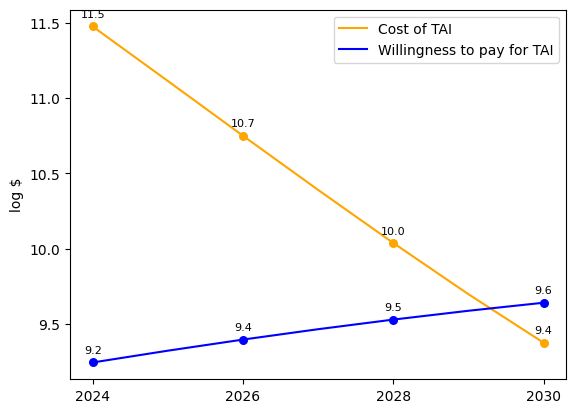

-
-
## SAMPLE RUN 48 ##

In this simulation:
* It takes 34.6 log FLOP (~39.8 decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.6 quintillion) per 2024$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~941.6 sextillion) per 2024$USD.
* We are initially willing to pay 8.8 log 2024$USD (~573.4 million).
* This doubles every 2.4 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.039x per year.
---
2024 - TAI takes 34.6 logFLOP which costs 15.9 log 2024$USD to buy vs. WTP at 8.7 (buys 27.4 log FLOP or 27.4 2024-log-eFLOP)
2025 - TAI takes 34.3 logFLOP which costs 15.6 log 2024$USD to buy vs. WTP at 8.8 (buys 27.6 log FLOP or 27.9 2024-log-eFLOP)
2026 - TAI takes 34.1 logFLOP which costs 15.2 log 2024$USD to buy vs. WTP at 8.9 (buys 27.8 log FLOP or 28.3 2024-log-eFLOP)
2027 - TAI takes 33.8 logFLOP which costs 1

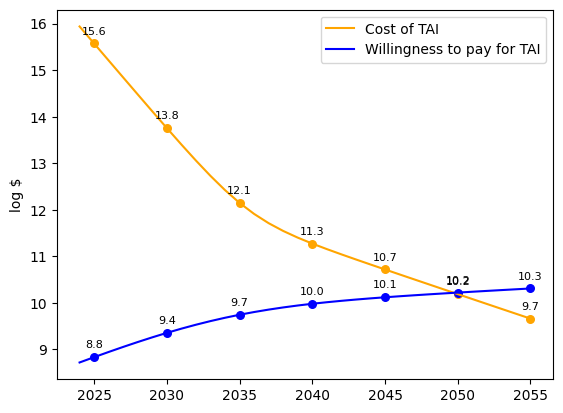

-
-
## SAMPLE RUN 49 ##

In this simulation:
* It takes 40.1 log FLOP (~12.6 million decillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.2 quintillion) per 2024$USD.
* Every 3.3 years they get 2x cheaper, to a maximum of 25.5 log FLOP (~32.8 septillion) per 2024$USD.
* We are initially willing to pay 8.9 log 2024$USD (~767.5 million).
* This doubles every 2.6 year to a max of 0.090428% of GDP (initially ~22.7 billion 2024$USD).
* GDP grows at a rate of 1.014x per year.
---
2024 - TAI takes 40.1 logFLOP which costs 21.5 log 2024$USD to buy vs. WTP at 8.9 (buys 27.5 log FLOP or 27.5 2024-log-eFLOP)
2025 - TAI takes 39.9 logFLOP which costs 21.2 log 2024$USD to buy vs. WTP at 9.0 (buys 27.7 log FLOP or 27.9 2024-log-eFLOP)
2026 - TAI takes 39.8 logFLOP which costs 21.0 log 2024$USD to buy vs. WTP at 9.1 (buys 27.9 log FLOP or 28.2 2024-log-eFLOP)
2027 - TAI takes 39.6 logFLOP wh

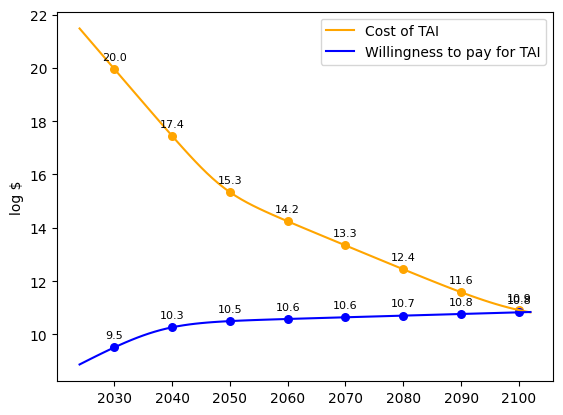

-
-
## SAMPLE RUN 50 ##

In this simulation:
* It takes 29.3 log FLOP (~199.5 octillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.0 quintillion) per 2024$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~246.9 sextillion) per 2024$USD.
* We are initially willing to pay 9.4 log 2024$USD (~2.4 billion).
* This doubles every 3.4 year to a max of 0.025279% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.03x per year.
---
2024 - TAI takes 29.3 logFLOP which costs 11.0 log 2024$USD to buy vs. WTP at 9.2 (buys 27.6 log FLOP or 27.6 2024-log-eFLOP)
2025 - TAI takes 29.1 logFLOP which costs 10.7 log 2024$USD to buy vs. WTP at 9.3 (buys 27.7 log FLOP or 27.9 2024-log-eFLOP)
2026 - TAI takes 28.9 logFLOP which costs 10.4 log 2024$USD to buy vs. WTP at 9.4 (buys 27.9 log FLOP or 28.3 2024-log-eFLOP)
2027 - TAI takes 28.7 logFLOP which costs 

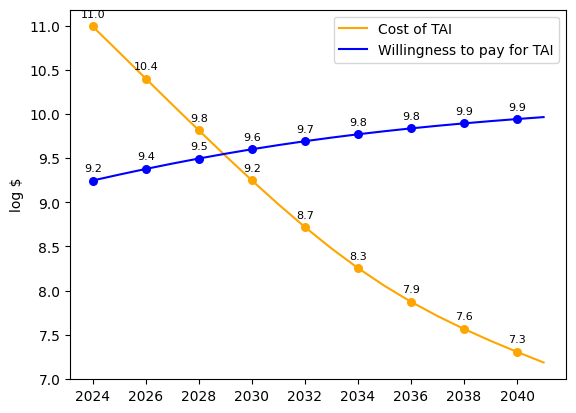

-
-
## SAMPLE RUN 51 ##

In this simulation:
* It takes 44.1 log FLOP (~125.9 billion decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~14.6 quintillion) per 2024$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~158.3 sextillion) per 2024$USD.
* We are initially willing to pay 9.4 log 2024$USD (~2.8 billion).
* This doubles every 1.4 year to a max of 0.025% of GDP (initially ~6.3 billion 2024$USD).
* GDP grows at a rate of 1.023x per year.
---
2024 - TAI takes 44.1 logFLOP which costs 24.9 log 2024$USD to buy vs. WTP at 9.3 (buys 28.5 log FLOP or 28.5 2024-log-eFLOP)
2025 - TAI takes 43.8 logFLOP which costs 24.5 log 2024$USD to buy vs. WTP at 9.4 (buys 28.7 log FLOP or 29.0 2024-log-eFLOP)
2026 - TAI takes 43.5 logFLOP which costs 24.1 log 2024$USD to buy vs. WTP at 9.5 (buys 28.9 log FLOP or 29.5 2024-log-eFLOP)
2027 - TAI takes 43.2 logFLOP which

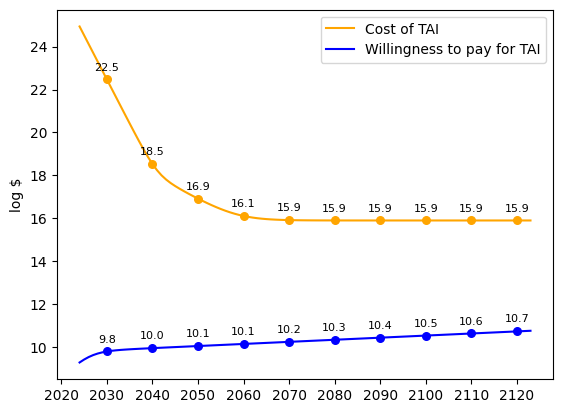

-
-
## SAMPLE RUN 52 ##

In this simulation:
* It takes 40.6 log FLOP (~39.8 million decillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.6 quintillion) per 2024$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~142.0 sextillion) per 2024$USD.
* We are initially willing to pay 8.8 log 2024$USD (~584.6 million).
* This doubles every 5.9 year to a max of 0.031745% of GDP (initially ~8.0 billion 2024$USD).
* GDP grows at a rate of 1.017x per year.
---
2024 - TAI takes 40.6 logFLOP which costs 22.4 log 2024$USD to buy vs. WTP at 8.7 (buys 27.0 log FLOP or 27.0 2024-log-eFLOP)
2025 - TAI takes 40.4 logFLOP which costs 22.1 log 2024$USD to buy vs. WTP at 8.8 (buys 27.1 log FLOP or 27.3 2024-log-eFLOP)
2026 - TAI takes 40.3 logFLOP which costs 21.8 log 2024$USD to buy vs. WTP at 8.8 (buys 27.3 log FLOP or 27.7 2024-log-eFLOP)
2027 - TAI takes 40.1 logFLOP wh

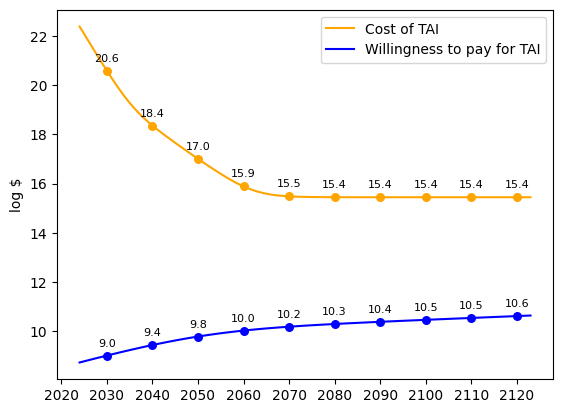

-
-
## SAMPLE RUN 53 ##

In this simulation:
* It takes 33.5 log FLOP (~3.2 decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.5 quintillion) per 2024$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~2.4 septillion) per 2024$USD.
* We are initially willing to pay 9.1 log 2024$USD (~1.1 billion).
* This doubles every 6.3 year to a max of 0.048523% of GDP (initially ~12.0 billion 2024$USD).
* GDP grows at a rate of 1.023x per year.
---
2024 - TAI takes 33.5 logFLOP which costs 14.8 log 2024$USD to buy vs. WTP at 9.0 (buys 27.8 log FLOP or 27.8 2024-log-eFLOP)
2025 - TAI takes 33.1 logFLOP which costs 14.3 log 2024$USD to buy vs. WTP at 9.1 (buys 27.9 log FLOP or 28.3 2024-log-eFLOP)
2026 - TAI takes 32.7 logFLOP which costs 13.8 log 2024$USD to buy vs. WTP at 9.1 (buys 28.0 log FLOP or 28.8 2024-log-eFLOP)
2027 - TAI takes 32.3 logFLOP which costs 13

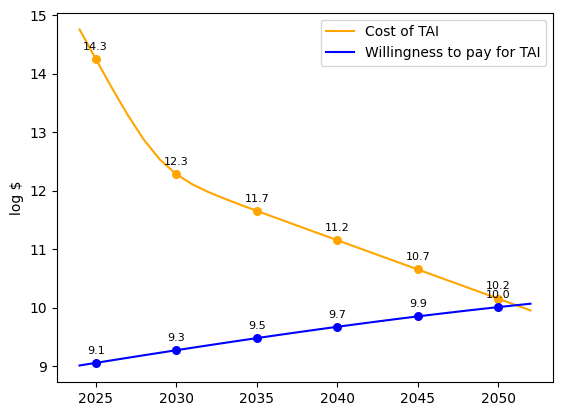

In [14]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [15]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2024-03-15 18:55:57.998507
